In [1]:
import re
import time
import math
import pandas as pd
import numpy as np
import seaborn as sns
#plt.style.use('seaborn')
from matplotlib import pyplot as plt
%matplotlib inline
from scipy import stats
from scipy.stats.mstats import winsorize
from scipy.stats import boxcox
from matplotlib import pyplot
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import binarize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.decomposition import PCA
from datetime import datetime

# Predicting if an MTA Bus Will Be Late.

## Introduction 

Metropolitan Transportation Authority(MTA) busses in New York city are notorious for being slow and late. For this project we will take a look at a data set from Kaggle and see how accurately we can determine if a bus is going to be late or not. A useful model will be able to be interpreted so that solutions can be developed to improve the bus service performance but we will also be trying to see how accurate wecan get the predictions. 

In [2]:
 # Load data 
#mta = pd.read_csv('C:/Users/keith/Desktop/Thinkful/mta_1706.csv',encoding = "ISO-8859-1",error_bad_lines=False)
mta_bus = pd.read_csv('C:/Users/keith/Desktop/Thinkful/mta_1706_1.csv',encoding = "ISO-8859-1",error_bad_lines=False)
pd.set_option('display.max_columns', 50)

b'Skipping line 53192: expected 17 fields, saw 18\nSkipping line 56712: expected 17 fields, saw 18\nSkipping line 64874: expected 17 fields, saw 18\n'
b'Skipping line 80636: expected 17 fields, saw 18\nSkipping line 97072: expected 17 fields, saw 18\n'
b'Skipping line 107697: expected 17 fields, saw 18\nSkipping line 109317: expected 17 fields, saw 18\nSkipping line 119951: expected 17 fields, saw 18\n'
b'Skipping line 134667: expected 17 fields, saw 18\nSkipping line 139923: expected 17 fields, saw 18\nSkipping line 144309: expected 17 fields, saw 18\nSkipping line 157927: expected 17 fields, saw 18\nSkipping line 158907: expected 17 fields, saw 18\nSkipping line 161424: expected 17 fields, saw 18\n'
b'Skipping line 173221: expected 17 fields, saw 18\nSkipping line 173623: expected 17 fields, saw 18\nSkipping line 177253: expected 17 fields, saw 18\nSkipping line 181883: expected 17 fields, saw 18\nSkipping line 186684: expected 17 fields, saw 18\nSkipping line 191267: expected 17 fie

b'Skipping line 2831078: expected 17 fields, saw 18\nSkipping line 2831884: expected 17 fields, saw 18\nSkipping line 2832778: expected 17 fields, saw 18\n'
b'Skipping line 2935466: expected 17 fields, saw 18\nSkipping line 2937968: expected 17 fields, saw 18\n'
b'Skipping line 2952504: expected 17 fields, saw 18\n'
b'Skipping line 2982958: expected 17 fields, saw 18\nSkipping line 2991335: expected 17 fields, saw 18\nSkipping line 3006710: expected 17 fields, saw 18\nSkipping line 3013361: expected 17 fields, saw 18\n'
b'Skipping line 3019557: expected 17 fields, saw 18\nSkipping line 3032671: expected 17 fields, saw 18\n'
b'Skipping line 3068454: expected 17 fields, saw 18\nSkipping line 3079236: expected 17 fields, saw 18\n'
b'Skipping line 3081942: expected 17 fields, saw 18\nSkipping line 3095240: expected 17 fields, saw 18\n'
b'Skipping line 3166450: expected 17 fields, saw 18\nSkipping line 3178126: expected 17 fields, saw 18\n'
b'Skipping line 3192452: expected 17 fields, saw 1

b'Skipping line 5158386: expected 17 fields, saw 18\n'
b'Skipping line 5278636: expected 17 fields, saw 18\n'
b'Skipping line 5389023: expected 17 fields, saw 18\nSkipping line 5393062: expected 17 fields, saw 18\n'
b'Skipping line 5410409: expected 17 fields, saw 18\n'
b'Skipping line 5444054: expected 17 fields, saw 18\n'
b'Skipping line 5496628: expected 17 fields, saw 18\nSkipping line 5496629: expected 17 fields, saw 18\n'
b'Skipping line 5510776: expected 17 fields, saw 18\n'
b'Skipping line 5548626: expected 17 fields, saw 18\nSkipping line 5551773: expected 17 fields, saw 18\nSkipping line 5556312: expected 17 fields, saw 18\nSkipping line 5570453: expected 17 fields, saw 18\n'
b'Skipping line 5577387: expected 17 fields, saw 18\nSkipping line 5580723: expected 17 fields, saw 18\nSkipping line 5582075: expected 17 fields, saw 18\nSkipping line 5596334: expected 17 fields, saw 18\nSkipping line 5602325: expected 17 fields, saw 18\n'
b'Skipping line 5606005: expected 17 fields, s

In [3]:
#take sample because the full set is too much to try to analyze on local machine
mta = mta_bus.sample(n=10000,random_state=20)

# Data Description

In [4]:
mta.head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation.Latitude,VehicleLocation.Longitude,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime
249431,2017-06-02 00:05:00,1,Q17,138 ST/37 AV,40.761806,-73.829559,JAMAICA ARCHER AV,40.704933,-73.793320,NYCT_8442,40.712529,-73.784314,HILLSIDE AV/EDGERTON BL,approaching,128.0,NaN,23:58:34
5083624,2017-06-23 16:20:48,0,B44-SBS,KNAPP ST/SHORE PKY,40.585033,-73.931328,SBS WLMSBRG BRDG PLZ via NSTRND via RGRS,40.709316,-73.959587,NYCT_5357,40.603164,-73.942410,NOSTRAND AV/KINGS HY,0.9 miles away,1427.0,2017-06-23 16:26:00,16:26:16
2001707,2017-06-09 17:38:05,1,Bx9,NaN,NaN,NaN,WEST FARMS,40.840641,-73.879807,NYCT_1214,40.879992,-73.904038,BROADWAY/W 231 ST,approaching,120.0,2017-06-09 17:39:19,NaN
2315680,2017-06-11 15:10:33,1,Bx41,WHITE PLAINS RD/E GUN HILL RD,40.877853,-73.866669,THE HUB 150 ST via WEBSTER,40.816887,-73.917488,NYCT_5538,40.819222,-73.916341,MELROSE AV/E 152 ST,< 1 stop away,154.0,2017-06-11 15:11:24,14:59:05
2230060,2017-06-10 22:20:22,1,B1,87 ST/4 Av,40.621925,-74.028496,MANHATTAN BEACH KINGSBORO CC,40.578094,-73.940170,NYCT_7158,40.576590,-73.968469,BRIGHTON BEACH AV/OCEAN PY,approaching,104.0,2017-06-10 22:20:58,22:21:22


In [5]:
 mta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 249431 to 2109709
Data columns (total 17 columns):
RecordedAtTime               10000 non-null object
DirectionRef                 10000 non-null int64
PublishedLineName            10000 non-null object
OriginName                   9915 non-null object
OriginLat                    9915 non-null float64
OriginLong                   9915 non-null float64
DestinationName              10000 non-null object
DestinationLat               9991 non-null float64
DestinationLong              9991 non-null float64
VehicleRef                   10000 non-null object
VehicleLocation.Latitude     10000 non-null float64
VehicleLocation.Longitude    10000 non-null float64
NextStopPointName            9989 non-null object
ArrivalProximityText         9989 non-null object
DistanceFromStop             9989 non-null float64
ExpectedArrivalTime          8662 non-null object
ScheduledArrivalTime         9756 non-null object
dtypes: float64(7), i

In [6]:
mta.shape

(10000, 17)

# Data cleaning

In [7]:
mta.duplicated().sum()

0

In [8]:
#pd.set_option('display.max_columns', None) # disables trucated columns 
#pd.set_option('display.max_rows', None) # disables trucated rows
mta.head()   

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation.Latitude,VehicleLocation.Longitude,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime
249431,2017-06-02 00:05:00,1,Q17,138 ST/37 AV,40.761806,-73.829559,JAMAICA ARCHER AV,40.704933,-73.793320,NYCT_8442,40.712529,-73.784314,HILLSIDE AV/EDGERTON BL,approaching,128.0,NaN,23:58:34
5083624,2017-06-23 16:20:48,0,B44-SBS,KNAPP ST/SHORE PKY,40.585033,-73.931328,SBS WLMSBRG BRDG PLZ via NSTRND via RGRS,40.709316,-73.959587,NYCT_5357,40.603164,-73.942410,NOSTRAND AV/KINGS HY,0.9 miles away,1427.0,2017-06-23 16:26:00,16:26:16
2001707,2017-06-09 17:38:05,1,Bx9,NaN,NaN,NaN,WEST FARMS,40.840641,-73.879807,NYCT_1214,40.879992,-73.904038,BROADWAY/W 231 ST,approaching,120.0,2017-06-09 17:39:19,NaN
2315680,2017-06-11 15:10:33,1,Bx41,WHITE PLAINS RD/E GUN HILL RD,40.877853,-73.866669,THE HUB 150 ST via WEBSTER,40.816887,-73.917488,NYCT_5538,40.819222,-73.916341,MELROSE AV/E 152 ST,< 1 stop away,154.0,2017-06-11 15:11:24,14:59:05
2230060,2017-06-10 22:20:22,1,B1,87 ST/4 Av,40.621925,-74.028496,MANHATTAN BEACH KINGSBORO CC,40.578094,-73.940170,NYCT_7158,40.576590,-73.968469,BRIGHTON BEACH AV/OCEAN PY,approaching,104.0,2017-06-10 22:20:58,22:21:22


In [9]:
mta.columns

Index(['RecordedAtTime', 'DirectionRef', 'PublishedLineName', 'OriginName',
       'OriginLat', 'OriginLong', 'DestinationName', 'DestinationLat',
       'DestinationLong', 'VehicleRef', 'VehicleLocation.Latitude',
       'VehicleLocation.Longitude', 'NextStopPointName',
       'ArrivalProximityText', 'DistanceFromStop', 'ExpectedArrivalTime',
       'ScheduledArrivalTime'],
      dtype='object')

In [10]:
mta.columns=['RecordedAtTime', 'DirectionRef', 'PublishedLineName', 'OriginName',
       'OriginLat', 'OriginLong', 'DestinationName', 'DestinationLat',
       'DestinationLong', 'VehicleRef', 'VehicleLocation_Lat',
       'VehicleLocation_Long', 'NextStopPointName',
       'ArrivalProximityText', 'DistanceFromStop', 'ExpectedArrivalTime',
       'ScheduledArrivalTime']

In [11]:
mta.isnull().sum()

RecordedAtTime             0
DirectionRef               0
PublishedLineName          0
OriginName                85
OriginLat                 85
OriginLong                85
DestinationName            0
DestinationLat             9
DestinationLong            9
VehicleRef                 0
VehicleLocation_Lat        0
VehicleLocation_Long       0
NextStopPointName         11
ArrivalProximityText      11
DistanceFromStop          11
ExpectedArrivalTime     1338
ScheduledArrivalTime     244
dtype: int64

In [12]:
(mta.isnull().sum()/mta.isnull().count()*100).astype(str)+" %"

RecordedAtTime                         0.0 %
DirectionRef                           0.0 %
PublishedLineName                      0.0 %
OriginName              0.8500000000000001 %
OriginLat               0.8500000000000001 %
OriginLong              0.8500000000000001 %
DestinationName                        0.0 %
DestinationLat                        0.09 %
DestinationLong                       0.09 %
VehicleRef                             0.0 %
VehicleLocation_Lat                    0.0 %
VehicleLocation_Long                   0.0 %
NextStopPointName                     0.11 %
ArrivalProximityText                  0.11 %
DistanceFromStop                      0.11 %
ExpectedArrivalTime                  13.38 %
ScheduledArrivalTime                  2.44 %
dtype: object

We need to drop the rows with missing arrival times. It is usless to us if we can't find the bus is late or not.

In [13]:
mta = mta[mta.ExpectedArrivalTime.isnull()==False]  
mta.isnull().sum()
 

RecordedAtTime           0
DirectionRef             0
PublishedLineName        0
OriginName              72
OriginLat               72
OriginLong              72
DestinationName          0
DestinationLat           6
DestinationLong          6
VehicleRef               0
VehicleLocation_Lat      0
VehicleLocation_Long     0
NextStopPointName        0
ArrivalProximityText     0
DistanceFromStop         0
ExpectedArrivalTime      0
ScheduledArrivalTime    72
dtype: int64

In [14]:
mta = mta[mta.ScheduledArrivalTime.isnull()==False]
mta.isnull().sum()

RecordedAtTime          0
DirectionRef            0
PublishedLineName       0
OriginName              0
OriginLat               0
OriginLong              0
DestinationName         0
DestinationLat          0
DestinationLong         0
VehicleRef              0
VehicleLocation_Lat     0
VehicleLocation_Long    0
NextStopPointName       0
ArrivalProximityText    0
DistanceFromStop        0
ExpectedArrivalTime     0
ScheduledArrivalTime    0
dtype: int64

In [15]:
len(mta)/200000

0.04295

In [16]:
# reindex dataset
mta.index = range(len(mta.index))

That took care of all of our null values, that we can tell anyway.

Next we need to create a target variable. We are trying to predict if a bus is going to be late or not so we will convert the time rows in to manageable data and the find the difference in times.

In [17]:
# modifying "ScheduledArrivalTime" format to match "EstimatedArrivalTime"
mta.loc[list(np.where(mta.ScheduledArrivalTime=='24:00:00')[0]),'ScheduledArrivalTime'] = '00:00:01'
mta['ScheduledArrivalTime'] = pd.to_timedelta(mta.ScheduledArrivalTime)
mta['ScheduledArrivalTime'] = pd.to_timedelta(mta.ScheduledArrivalTime)
mta['ScheduledArrivalTime'] = pd.to_datetime(mta.ScheduledArrivalTime)

# converting "ExpectedArrivalTime" to datetime format and them finding the diffence between ScheduledArrivalTime
# "ExpectedArrivalTime"
mta['ExpectedArrivalTime'] = pd.to_datetime(mta.ExpectedArrivalTime)
mta['ScheduledArrivalTime'] = mta.ExpectedArrivalTime.dt.date.astype('str') +' '+ mta.ScheduledArrivalTime.dt.time.astype('str')
mta['ScheduledArrivalTime'] = pd.to_datetime(mta.ScheduledArrivalTime)
mta['ScheduledArrivalTime'] = pd.to_datetime(mta.ScheduledArrivalTime)
index = mta[(mta.ScheduledArrivalTime.dt.hour==23) & (mta.ExpectedArrivalTime.dt.hour==00)].index
mta.loc[index,'ScheduledArrivalTime'] = mta.ScheduledArrivalTime + pd.DateOffset(days=-1)

# Finally creating a binary target "Late_bus"
mta.loc[list(np.where(mta.ExpectedArrivalTime>mta.ScheduledArrivalTime)[0]),'Time_delay'] = pd.to_datetime(mta.ExpectedArrivalTime -  mta.ScheduledArrivalTime).dt.minute 
mta.loc[list(np.where(mta.ExpectedArrivalTime<mta.ScheduledArrivalTime)[0]),'Time_delay'] = pd.to_datetime(mta.ScheduledArrivalTime - mta.ExpectedArrivalTime ).dt.minute*-1
mta.loc[list(np.where(mta.Time_delay.isna()==True)[0]),'Time_delay'] = 0

mta['Late_Bus'] = np.where(mta.Time_delay>7, 1, 0)

In [18]:
# checking to make sure that time is only in the month of June
mta.ScheduledArrivalTime.dt.month.unique()

array([6], dtype=int64)

In [19]:
mta.drop(list(np.where(mta.ScheduledArrivalTime.dt.month==5)[0]),axis='index',inplace=True)
# reindex dataset
mta.index = range(len(mta.index))
mta.ScheduledArrivalTime.dt.month.unique()

array([6], dtype=int64)

In [20]:
# test to see if it worked from a sample
mta.sample(frac=.001).head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation_Lat,VehicleLocation_Long,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime,Time_delay,Late_Bus
4328,2017-06-26 21:16:02,1,B4,KNAPP ST/HARKNESS AV,40.586441,-73.931587,BAY RIDGE NARROWS AV,40.631718,-74.036407,NYCT_782,40.587594,-73.974212,SHELL RD/BOUCK CT,< 1 stop away,155.0,2017-06-26 21:16:33,2017-06-26 21:02:53,13.0,1
1618,2017-06-23 21:30:48,1,Q1,BRADDOCK AV/CROSS ISLAND PY,40.725830,-73.725060,JAMAICA 165 ST TERM,40.707615,-73.795540,NYCT_6484,40.707821,-73.795535,165 ST / 165 ST TERM,at stop,21.0,2017-06-23 21:31:04,2017-06-23 21:33:00,-1.0,0
7051,2017-06-26 21:16:10,0,Q5,TEARDROP/LAYOVER,40.701748,-73.802399,GREEN ACRES via MERRICK,40.661846,-73.723145,NYCT_8402,40.702364,-73.800373,ARCHER AV /PARSONS BL,at stop,19.0,2017-06-26 21:16:42,2017-06-26 21:17:00,0.0,0
7831,2017-06-07 13:55:11,1,Bx38,BAY PZ/BARTOW AV,40.866772,-73.825073,NORWOOD 205 ST STATION via GUNHILL,40.874424,-73.879517,NYCT_4417,40.866233,-73.825136,BAY PLAZA BL/APPLEBEE'S,< 1 stop away,204.0,2017-06-07 13:55:47,2017-06-07 14:01:02,-5.0,0
4739,2017-06-19 02:43:54,0,B46,FLATBUSH AV/KINGS PLAZA,40.609566,-73.921814,BRIDGE PLZ via UTICA,40.709404,-73.959564,NYCT_4242,40.674435,-73.930587,UTICA AV/BERGEN ST,approaching,102.0,2017-06-19 02:44:12,2017-06-19 02:45:07,0.0,0


The conversion worked. We created a feature 'Time_delay' where the values are the minutes of delay ot the bus. Values that are greater than zero are the number of minutes past the scheduled arrival time. The values that are less that zero are the number of minutes the bus arrived ahead of schedule.

The 'Late_Bus' feature is labels a '1' for a bus who's arrival time is greater than 15 min past the scheduled arrival time and labels a '0' for anything under that time. This is our target

In [21]:
mta.head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation_Lat,VehicleLocation_Long,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime,Time_delay,Late_Bus
0,2017-06-23 16:20:48,0,B44-SBS,KNAPP ST/SHORE PKY,40.585033,-73.931328,SBS WLMSBRG BRDG PLZ via NSTRND via RGRS,40.709316,-73.959587,NYCT_5357,40.603164,-73.942410,NOSTRAND AV/KINGS HY,0.9 miles away,1427.0,2017-06-23 16:26:00,2017-06-23 16:26:16,0.0,0
1,2017-06-11 15:10:33,1,Bx41,WHITE PLAINS RD/E GUN HILL RD,40.877853,-73.866669,THE HUB 150 ST via WEBSTER,40.816887,-73.917488,NYCT_5538,40.819222,-73.916341,MELROSE AV/E 152 ST,< 1 stop away,154.0,2017-06-11 15:11:24,2017-06-11 14:59:05,12.0,1
2,2017-06-10 22:20:22,1,B1,87 ST/4 Av,40.621925,-74.028496,MANHATTAN BEACH KINGSBORO CC,40.578094,-73.940170,NYCT_7158,40.576590,-73.968469,BRIGHTON BEACH AV/OCEAN PY,approaching,104.0,2017-06-10 22:20:58,2017-06-10 22:21:22,0.0,0
3,2017-06-14 10:06:11,1,B62,JACKSON AV/QUEENS PZ S,40.748638,-73.938446,DOWNTOWN BKLYN FULTON MALL,40.690407,-73.989471,NYCT_4519,40.712838,-73.960482,DRIGGS AV/S 2 ST,approaching,49.0,2017-06-14 10:06:27,2017-06-14 09:59:15,7.0,0
4,2017-06-28 17:09:54,1,Q76,132 ST/20 AV,40.782063,-73.836716,JAMAICA 165 ST TERM via F LEWIS,40.707615,-73.795540,NYCT_4195,40.715189,-73.773367,HILLSIDE AV/188 ST,at stop,8.0,2017-06-28 17:10:08,2017-06-28 17:03:28,6.0,0


In [22]:
mta.Late_Bus.value_counts()

0    6287
1    2303
Name: Late_Bus, dtype: int64

    Next, "ArrivalProximityText" and "DistanceFromStop" are redundant variables so one can be dropped.

In [23]:
mta.drop("ArrivalProximityText",1,inplace=True)

In [24]:
# convert the categorical variables to the correct data type
columns = ['DirectionRef','PublishedLineName','OriginName',
           'DestinationName','VehicleRef','NextStopPointName']
for col in columns:
    mta[col] = mta[col].astype('category')
    
mta['RecordedAtTime'] = pd.to_datetime(mta.RecordedAtTime)

In [25]:
# breaking up "ScheduledArrivalTime" into components
mta['day'] = pd.to_numeric(mta.ScheduledArrivalTime.dt.day)
mta['hour'] = pd.to_numeric(mta.ScheduledArrivalTime.dt.hour)
mta['minute'] = pd.to_numeric(mta.ScheduledArrivalTime.dt.minute)
mta['weekday'] = mta.ScheduledArrivalTime.dt.day_name().astype('category')
mta['day_of_week'] = pd.to_numeric(mta.ScheduledArrivalTime.dt.weekday)

In [26]:
# sort dataframe by Scheduled arrival time
mta.index = mta.ScheduledArrivalTime
mta = mta.sort_index()
mta.index = range(len(mta))

In [27]:
mta.head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation_Lat,VehicleLocation_Long,NextStopPointName,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime,Time_delay,Late_Bus,day,hour,minute,weekday,day_of_week
0,2017-06-01 00:13:38,0,B38,TILLARY ST/CADMAN PZ E,40.696106,-73.990364,RIDGEWOOD METRO AV,40.713341,-73.914688,NYCT_7228,40.687247,-73.976757,FULTON ST/LAFAYETTE AV,10.0,2017-06-01 00:13:57,2017-06-01 00:14:50,0.0,0,1,0,14,Thursday,3
1,2017-06-01 00:33:36,0,M2,4 AV/E 10 ST,40.731342,-73.990288,WASHINGTON HTS BWAY - 168 ST via MADISON,40.840580,-73.938431,NYCT_6420,40.801363,-73.953772,ADAM C POWELL BL/W 113 ST,19.0,2017-06-01 00:33:57,2017-06-01 00:30:41,3.0,0,1,0,30,Thursday,3
2,2017-06-01 00:43:30,0,Q30,ARCHER AV /SUTPHIN BL,40.700489,-73.807884,LITTLE NECK L NECK PKY,40.764297,-73.725914,NYCT_8089,40.718550,-73.791445,HOMELAWN ST/CHARLECOTE RIDGE,9.0,2017-06-01 00:43:41,2017-06-01 00:38:11,5.0,0,1,0,38,Thursday,3
3,2017-06-01 01:03:25,0,M86-SBS,W 86 ST/BROADWAY,40.788357,-73.976791,Select Bus Service Yorkville East End AV,40.780247,-73.946808,NYCT_5835,40.776936,-73.949519,E 86 ST/1 AV,30.0,2017-06-01 01:03:49,2017-06-01 01:00:12,3.0,0,1,1,0,Thursday,3
4,2017-06-01 02:13:37,1,B15,JFK AIRPORT/TERMINAL 5 AirTrain STATION,40.647278,-73.779633,BED-STUY WOODHULL HOSP,40.699776,-73.941505,NYCT_6810,40.663602,-73.889098,NEW LOTS AV/WYONA ST,180.0,2017-06-01 02:14:09,2017-06-01 02:12:21,1.0,0,1,2,12,Thursday,3


# Exploratory Data Analysis

In [28]:
mta.columns

Index(['RecordedAtTime', 'DirectionRef', 'PublishedLineName', 'OriginName',
       'OriginLat', 'OriginLong', 'DestinationName', 'DestinationLat',
       'DestinationLong', 'VehicleRef', 'VehicleLocation_Lat',
       'VehicleLocation_Long', 'NextStopPointName', 'DistanceFromStop',
       'ExpectedArrivalTime', 'ScheduledArrivalTime', 'Time_delay', 'Late_Bus',
       'day', 'hour', 'minute', 'weekday', 'day_of_week'],
      dtype='object')

In [29]:
mta.describe()

,OriginLat,OriginLong,DestinationLat,DestinationLong,VehicleLocation_Lat,VehicleLocation_Long,DistanceFromStop,Time_delay,Late_Bus,day,hour,minute,day_of_week
count,8590.000000,8590.000000,8590.000000,8590.000000,8590.000000,8590.000000,8590.000000,8590.000000,8590.000000,8590.000000,8590.000000,8590.000000,8590.000000
mean,40.728821,-73.930428,40.729217,-73.930574,40.728458,-73.930037,236.629919,5.485914,0.268102,15.444587,13.109546,29.708265,2.778813
std,0.089728,0.092458,0.090121,0.093384,0.086486,0.087116,950.293921,9.175294,0.442997,8.713758,5.362469,17.312961,1.821520
min,40.506882,-74.246948,40.508106,-74.246948,40.504312,-74.248756,0.000000,-29.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,40.657738,-73.987022,40.660854,-73.988831,40.658320,-73.977278,33.000000,0.000000,0.000000,8.000000,9.000000,15.000000,1.000000
50%,40.713348,-73.932449,40.713356,-73.932060,40.722908,-73.935492,102.500000,3.000000,0.000000,15.000000,14.000000,30.000000,3.000000
75%,40.807869,-73.879936,40.807545,-73.878326,40.803245,-73.882875,214.000000,8.000000,1.000000,23.000000,17.000000,45.000000,4.000000
max,40.912365,-73.701866,40.912376,-73.701385,40.911098,-73.701559,29887.000000,59.000000,1.000000,30.000000,23.000000,59.000000,6.000000


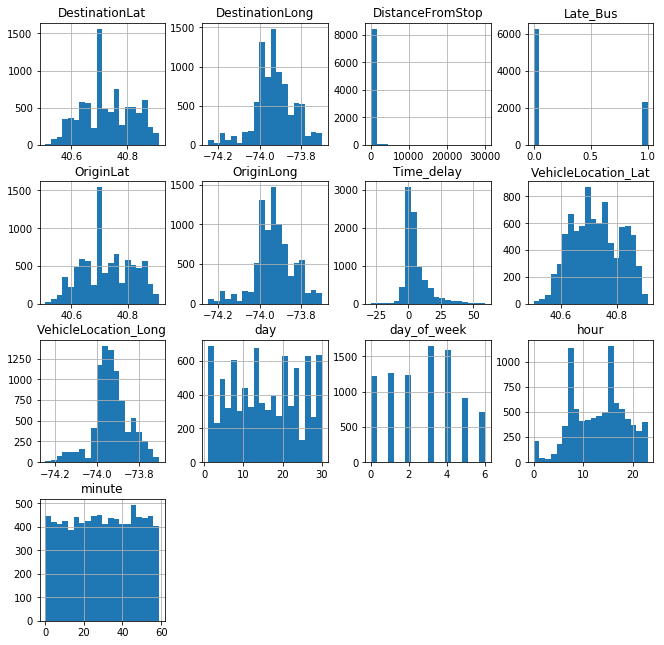

In [30]:
mta.hist(figsize=(11,11),bins=20)
plt.show()

From the histograms of our continuous features we can see that we have a very unbalanced target, which would be expected. There should definetly be more on-time busses that late ones. From here I want to look at the continuous variables for against the target.
 

In [31]:
# Test of the mean distance between stops of late and on-time busses
Late_Bus_dist = mta[mta.Late_Bus==1] 
On_Time_Bus_dist = mta[mta.Late_Bus==0] 
print(stats.ttest_ind(Late_Bus_dist.DistanceFromStop,On_Time_Bus_dist.DistanceFromStop),'\n')

# calculate correlation distance from stop and late busses
print('Correlation of distance from stops and late busses \n',mta.DistanceFromStop.corr(mta.Late_Bus))
print()
print(stats.ttest_ind(Late_Bus_dist.Time_delay,On_Time_Bus_dist.Time_delay),'\n')

 

Ttest_indResult(statistic=2.7787024334065773, pvalue=0.0054695070396597305) 

Correlation of distance from stops and late busses 
 0.029970975682985502

Ttest_indResult(statistic=111.03900922073927, pvalue=0.0) 



There is a statistically significant difference in the average distance from stop of Late busses and on-time busses. There is also a positive correlation between distance from stop and late busses.

In [32]:
mta[['Time_delay','DistanceFromStop']].describe()

,Time_delay,DistanceFromStop
count,8590.000000,8590.000000
mean,5.485914,236.629919
std,9.175294,950.293921
min,-29.000000,0.000000
25%,0.000000,33.000000
50%,3.000000,102.500000
75%,8.000000,214.000000
max,59.000000,29887.000000


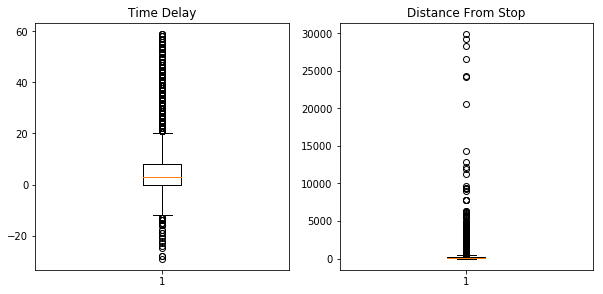

In [33]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.boxplot(mta.Time_delay)
plt.title('Time Delay')
plt.subplot(222)
plt.title('Distance From Stop')
plt.boxplot(mta.DistanceFromStop) 
plt.show()

Nothing will be done to correct the outliers in the Time Delay variable. We used this to create out target variable and it will not be used in any models. As far a the distance from stop variable we can look at winzorizing to minimize the outliers.

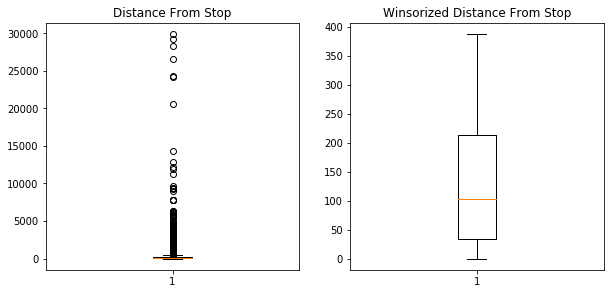

In [34]:
winsor_dist = winsorize(mta["DistanceFromStop"], (0, .1)) # one way wizorization of distance from stop 
#                                                           variable with limit set at the 90th percentile

plt.figure(figsize=(10,10))
plt.title('Distance From Stop') 
plt.subplot(221)
plt.title('Distance From Stop')
plt.boxplot(mta.DistanceFromStop) 


plt.subplot(222)
plt.title('Winsorized Distance From Stop')
plt.boxplot(winsor_dist)
plt.show()

In [35]:
# create a feature for winsorization of the distance from stops
mta['winsor_dist'] = winsor_dist 

In [36]:
mta.sample(frac=.1)[:10]

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation_Lat,VehicleLocation_Long,NextStopPointName,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime,Time_delay,Late_Bus,day,hour,minute,weekday,day_of_week,winsor_dist
291,2017-06-01 19:35:04,1,M31,E 92 ST/YORK AV,40.779755,-73.944534,CLINTON 11 AV via 57 ST,40.768192,-73.992546,NYCT_3827,40.768253,-73.992502,W 54 ST/11 AV,0.0,2017-06-01 19:35:18,2017-06-01 19:22:00,13.0,1,1,19,22,Thursday,3,0.0
2014,2017-06-07 23:35:00,1,Bx12,BAY PLAZA BL/APPLEBEE'S,40.866287,-73.826859,INWOOD BWY-207 ST- PEL PKY via FRDHAM RD,40.867786,-73.920547,NYCT_4769,40.862752,-73.904487,W FORDHAM RD/UNIVERSITY AV,55.0,2017-06-07 23:35:29,2017-06-07 23:31:00,4.0,0,7,23,31,Wednesday,2,55.0
2856,2017-06-11 03:20:24,0,X1,ELTINGVILLE/TRANSIT CENTER,40.560760,-74.171089,W MDTWN CNTRL PK S. via CHURCH via 6 AV,40.766006,-73.976807,NYCT_2742,40.587060,-74.091536,HYLAN BL/CROMWELL AV,106.0,2017-06-11 03:20:55,2017-06-11 03:22:21,-1.0,0,11,3,22,Sunday,6,106.0
5179,2017-06-19 08:13:18,0,Bx7,ST NICHOLAS AV/W 167 ST,40.840931,-73.939499,RIVERDALE 263 ST,40.912376,-73.902534,NYCT_4365,40.864988,-73.928254,BROADWAY/DYCKMAN ST,137.0,2017-06-19 08:14:29,2017-06-19 08:12:42,1.0,0,19,8,12,Monday,0,137.0
1276,2017-06-05 15:41:01,1,Q1,BRADDOCK AV/CROSS ISLAND PY,40.725830,-73.725060,JAMAICA 165 ST TERM,40.707615,-73.795540,NYCT_6865,40.716064,-73.770841,HILLSIDE AV/191 ST,58.0,2017-06-05 15:41:33,2017-06-05 15:41:48,0.0,0,5,15,41,Monday,0,58.0
6619,2017-06-23 18:21:08,0,Q30,ARCHER AV /SUTPHIN BL,40.700489,-73.807884,LITTLE NECK L NECK PKY,40.764297,-73.725914,NYCT_5158,40.748692,-73.757883,HORACE HARDING EXP/SPRINGFIELD BL,93.0,2017-06-23 18:21:28,2017-06-23 18:13:00,8.0,1,23,18,13,Friday,4,93.0
1201,2017-06-05 11:20:50,0,M60-SBS,BROADWAY/W 106 ST,40.801819,-73.967644,LA GUARDIA AIRPORT,40.768074,-73.862091,NYCT_5857,40.793647,-73.923580,HOYT AV/31 ST,3077.0,2017-06-05 11:27:06,2017-06-05 11:18:49,8.0,1,5,11,18,Monday,0,388.0
6004,2017-06-21 20:27:32,0,M23-SBS,12 AV/W 23 ST,40.748718,-74.008110,SELECT BUS EAST SIDE AVENUE C CROSSTOWN,40.733006,-73.974594,NYCT_5844,40.747612,-74.003988,W 23 ST/10 AV,26.0,2017-06-21 20:27:39,2017-06-21 20:26:52,0.0,0,21,20,26,Wednesday,2,26.0
4176,2017-06-15 09:37:48,0,Q15,ROOSEVELT AV/LAYOVER,40.758999,-73.831757,BEECHHURST POWELS COVE BL via 154 ST,40.793804,-73.797417,NYCT_4215,40.794154,-73.799716,162 ST/POWELL'S COVE BL,20.0,2017-06-15 09:37:52,2017-06-15 09:38:05,0.0,0,15,9,38,Thursday,3,20.0
8352,2017-06-30 08:52:13,0,B24,WASHINGTON PL/LANE 6,40.709259,-73.959633,GREENPOINT WEST ST,40.730087,-73.954575,NYCT_4331,40.720637,-73.940826,KINGSLAND AV/LOMBARDY ST,98.0,2017-06-30 08:52:48,2017-06-30 08:54:31,-1.0,0,30,8,54,Friday,4,98.0


# Categorical Variables

In [37]:
mta[['PublishedLineName', 'OriginName','DestinationName','VehicleRef','NextStopPointName']].describe()

,PublishedLineName,OriginName,DestinationName,VehicleRef,NextStopPointName
count,8590,8590,8590,8590,8590
unique,234,443,536,3574,4191
top,B6,E 126 ST/2 AV,WASHINGTON HTS GW BRIDGE,NYCT_4242,138 ST/37 AV
freq,165,134,108,10,20


# Late Busses and Time Delays by hour


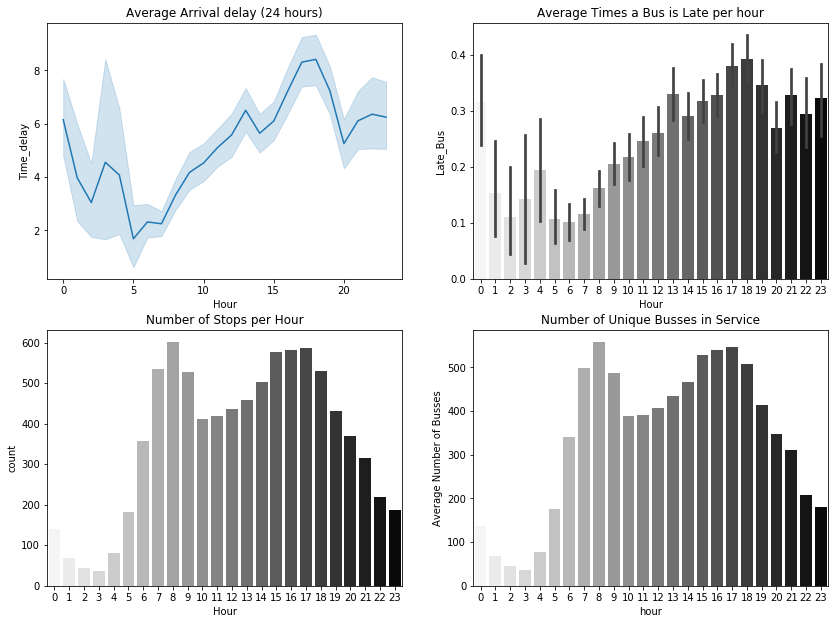

In [38]:
plt.figure(figsize=(14,16))
plt.subplot(321)
sns.lineplot(x= mta.ScheduledArrivalTime.dt.hour, 
             y=mta.Time_delay, data=mta,)
plt.title('Average Arrival delay (24 hours)') 
plt.xlabel('Hour')

plt.subplot(322)
sns.barplot(mta.ScheduledArrivalTime.dt.hour,mta[mta.DistanceFromStop<500].Late_Bus,palette= "gist_gray_r")
plt.title('Average Times a Bus is Late per hour')
plt.xlabel('Hour')

plt.subplot(323)
sns.countplot(mta.ScheduledArrivalTime.dt.hour, palette= "gist_gray_r")
plt.title('Number of Stops per Hour') 
plt.xlabel('Hour')

plt.subplot(324)
hour_df = pd.DataFrame(mta.groupby('hour').VehicleRef.unique())
hour_df = pd.DataFrame(hour_df.VehicleRef.apply(lambda x : len(x)))
plt.title('Number of Unique Busses in Service')
plt.xlabel('Hour')
plt.ylabel('Busses in Service')
hour_df['hour'] = hour_df.index
hour_df.index = range(len(hour_df))
sns.barplot(hour_df.hour, hour_df.VehicleRef, palette= "gist_gray_r")
plt.ylabel('Average Number of Busses')

plt.show()

After 6a.m. then average number of late busses steadily increases and peaks at 6p.m. It then flattens and falls between the hours of 1a.m. and 6a.m. This could be because there is less traffic at this time. 

In [39]:
index = mta[(mta.ScheduledArrivalTime.dt.hour>=8) & (mta.ScheduledArrivalTime.dt.hour<=19)].index  
mta['increased_Late'] = 0
mta.loc[index,'increased_Late'] = 1


In [40]:
mta.increased_Late.value_counts()

1    6062
0    2528
Name: increased_Late, dtype: int64

Here I am going to bin hours in to groups to form a feature that represents afternoon evening and night to caprture the differences in late busses during those times. 

In [41]:
# create time of day feature
bins=[-1, 5, 11, 16, 20, 23]
bin_names = ['night','morning','afternoon','evening','Night']
mta['time_of_day'] = pd.cut(mta.ScheduledArrivalTime.dt.hour, bins,labels=bin_names)
mta['time_of_day'] = mta['time_of_day'].str.lower().astype('category')

In [42]:
(mta.groupby(mta.time_of_day).Late_Bus.mean().sort_index(ascending=False)*100).astype(str)+" %"

time_of_day
night         25.47318611987382 %
morning       17.83081783081783 %
evening        35.9415753781951 %
afternoon    30.633802816901408 %
Name: Late_Bus, dtype: object

Afternoon and evening look to have the greatest average of late busses. Before looking I would have expected morning and evening to have the worse of the problem because of traffic at those times. Lets do a ttest to confirm that there is significant differences in the average number of late busses between each time of day.

In [43]:
# t-test between the means of the percentage of late busses of the hours in the day
tod_pvalues = {}
for i in range(len(mta.time_of_day.unique())):
        for j in range(i+1,4):
            print(mta.time_of_day.unique()[i],' vs ',mta.time_of_day
                  .unique()[j]) 
            print(stats.ttest_ind(
                mta[mta.time_of_day==mta.time_of_day.unique()[i]]['Late_Bus'], 
                mta[mta.time_of_day==mta.time_of_day.unique()[j]]['Late_Bus']))           

night  vs  morning
Ttest_indResult(statistic=5.660682663078201, pvalue=1.610406383661088e-08)
night  vs  afternoon
Ttest_indResult(statistic=-3.317485996499286, pvalue=0.0009168093248090943)
night  vs  evening
Ttest_indResult(statistic=-6.247340356692372, pvalue=4.72949013134202e-10)
morning  vs  afternoon
Ttest_indResult(statistic=-11.145408779539336, pvalue=1.5405654058506012e-28)
morning  vs  evening
Ttest_indResult(statistic=-14.439803749212354, pvalue=2.725907432509265e-46)
afternoon  vs  evening
Ttest_indResult(statistic=-3.74368104547944, pvalue=0.0001836230540383496)


 There looks to be significant diffences between each time of day.

### What percentage of busses are late per hour?


Here is a numerical representation of the graphs above.

In [44]:
(mta.groupby(mta.ScheduledArrivalTime.dt.hour).Late_Bus.mean().sort_index(ascending=False)*100).astype(str)+" %"

ScheduledArrivalTime
23     32.25806451612903 %
22     29.81651376146789 %
21     32.38095238095238 %
20    27.371273712737125 %
19     34.33874709976798 %
18    39.548022598870055 %
17    39.249146757679185 %
16     32.47422680412371 %
15     32.11805555555556 %
14    28.628230616302186 %
13    32.751091703056765 %
12     26.31578947368421 %
11     25.29832935560859 %
10    21.897810218978105 %
9     20.872865275142317 %
8      17.13810316139767 %
7     12.172284644194757 %
6      9.523809523809524 %
5       9.94475138121547 %
4                  18.75 %
3      13.88888888888889 %
2      11.11111111111111 %
1     14.705882352941178 %
0     30.935251798561154 %
Name: Late_Bus, dtype: object

# Late Busses and Time Delays by day of the Week

In [45]:
print('Description of Late Busses Delays by Weekday')
weekday_order={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
Late_bus_mean = mta[mta.Time_delay>=0].groupby(mta.ScheduledArrivalTime.dt.weekday).Late_Bus.describe()
Late_bus_mean.index = weekday_order.values()
Late_bus_mean

Description of Late Busses Delays by Weekday


,count,mean,std,min,25%,50%,75%,max
Monday,988.0,0.241903,0.428453,0.0,0.0,0.0,0.0,1.0
Tuesday,1060.0,0.322642,0.467708,0.0,0.0,0.0,1.0,1.0
Wednesday,1077.0,0.337047,0.472921,0.0,0.0,0.0,1.0,1.0
Thursday,1362.0,0.314978,0.464678,0.0,0.0,0.0,1.0,1.0
Friday,1352.0,0.321006,0.467036,0.0,0.0,0.0,1.0,1.0
Saturday,770.0,0.363636,0.481358,0.0,0.0,0.0,1.0,1.0
Sunday,622.0,0.347267,0.476485,0.0,0.0,0.0,1.0,1.0


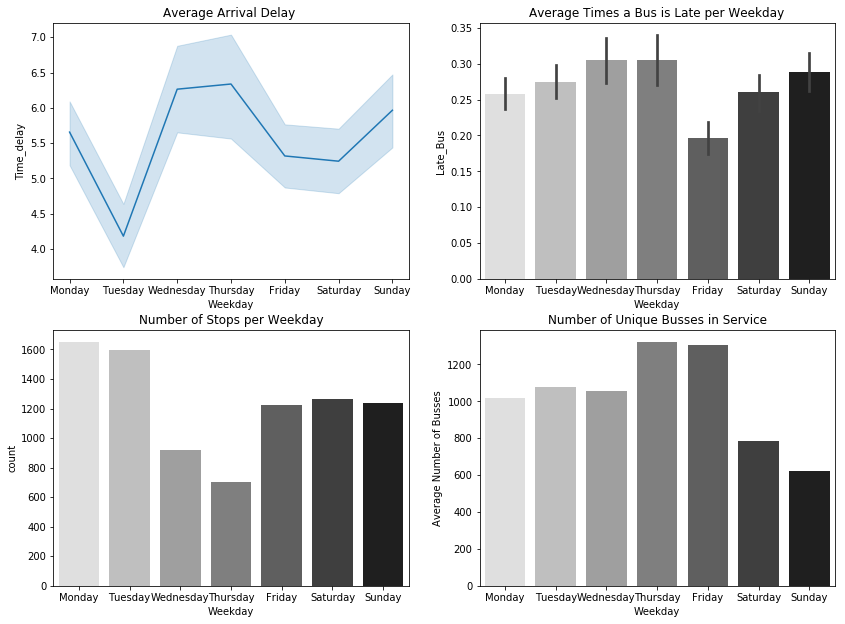

In [46]:
plt.figure(figsize=(14,16))
plt.subplot(321)
sns.lineplot(x= mta.ScheduledArrivalTime.dt.day_name(), 
             y=mta.Time_delay, data=mta)
plt.xticks(range(0,7), weekday_order.values())
plt.title('Average Arrival Delay ') 
plt.xlabel('Weekday')

plt.subplot(322)
sns.barplot(mta.ScheduledArrivalTime.dt.day_name(),mta[mta.DistanceFromStop<500].Late_Bus, palette= "gist_gray_r")
plt.title('Average Times a Bus is Late per Weekday')
plt.xticks(range(0,7), weekday_order.values())
plt.xlabel('Weekday')

plt.subplot(323)
sns.countplot(mta.ScheduledArrivalTime.dt.day_name(), palette= "gist_gray_r")
plt.xticks(range(0,7), weekday_order.values())
plt.title('Number of Stops per Weekday') 
plt.xlabel('Weekday')

plt.subplot(324)
day_df = pd.DataFrame(mta.groupby('day_of_week').VehicleRef.unique())
day_df = pd.DataFrame(day_df.VehicleRef.apply(lambda x : len(x)))
plt.title('Number of Unique Busses in Service')
plt.xlabel('Weekday')
plt.ylabel('Busses in Service')
day_df['Weekday'] = day_df.index
day_df.index = range(len(day_df))
sns.barplot(day_df.Weekday, day_df.VehicleRef,palette= "gist_gray_r")
plt.ylabel('Average Number of Busses')
plt.xticks(range(0,7),weekday_order.values())
plt.show()

In [47]:
#ttest between the means of the percentage of late busses of the days of the week
pvales = {}
for i in range(len(mta.ScheduledArrivalTime.dt.weekday.unique())):
        for j in range(i+1,7):
            print(mta.ScheduledArrivalTime.dt.day_name().unique()[i],' vs ',mta.ScheduledArrivalTime.dt.day_name().unique()[j]) 
            print(stats.ttest_ind(
                mta[mta.ScheduledArrivalTime.dt.day_name()==mta.ScheduledArrivalTime.dt.day_name().unique()[i]]['Late_Bus'], 
                mta[mta.ScheduledArrivalTime.dt.day_name()==mta.ScheduledArrivalTime.dt.day_name().unique()[j]]['Late_Bus']))
            pvales.update({(mta.ScheduledArrivalTime.dt.day_name().unique()[i],' vs ',mta.ScheduledArrivalTime.dt.day_name().unique()[j]):
                          stats.ttest_ind(
                          mta[mta.ScheduledArrivalTime.dt.day_name()==mta.ScheduledArrivalTime.dt.day_name().unique()[i]]['Late_Bus'], 
                          mta[mta.ScheduledArrivalTime.dt.day_name()==mta.ScheduledArrivalTime.dt.day_name().unique()[j]]['Late_Bus'])[1]})

Thursday  vs  Friday
Ttest_indResult(statistic=-0.7910047794468041, pvalue=0.4289990995939623)
Thursday  vs  Saturday
Ttest_indResult(statistic=-2.4719052002944966, pvalue=0.013504021004037827)
Thursday  vs  Sunday
Ttest_indResult(statistic=-2.304848421058598, pvalue=0.021261758069612773)
Thursday  vs  Monday
Ttest_indResult(statistic=4.093812574011029, pvalue=4.3604017847128185e-05)
Thursday  vs  Tuesday
Ttest_indResult(statistic=-0.6439185625692923, pvalue=0.5196789896835057)
Thursday  vs  Wednesday
Ttest_indResult(statistic=-1.957355332415289, pvalue=0.05040196172957504)
Friday  vs  Saturday
Ttest_indResult(statistic=-1.7767216002543835, pvalue=0.07573529232309095)
Friday  vs  Sunday
Ttest_indResult(statistic=-1.6662522233675399, pvalue=0.09579959188132042)
Friday  vs  Monday
Ttest_indResult(statistic=4.791125668316797, pvalue=1.7444225057689714e-06)
Friday  vs  Tuesday
Ttest_indResult(statistic=0.09889667244278474, pvalue=0.9212272562740861)
Friday  vs  Wednesday
Ttest_indResult(st

In [48]:
# find all comparisons with pvalues > .05
non_significant = [i for i in pvales if pvales.get(i)>.05]
non_significant

[('Thursday', ' vs ', 'Friday'),
 ('Thursday', ' vs ', 'Tuesday'),
 ('Thursday', ' vs ', 'Wednesday'),
 ('Friday', ' vs ', 'Saturday'),
 ('Friday', ' vs ', 'Sunday'),
 ('Friday', ' vs ', 'Tuesday'),
 ('Friday', ' vs ', 'Wednesday'),
 ('Saturday', ' vs ', 'Sunday'),
 ('Saturday', ' vs ', 'Tuesday'),
 ('Saturday', ' vs ', 'Wednesday'),
 ('Sunday', ' vs ', 'Tuesday'),
 ('Sunday', ' vs ', 'Wednesday'),
 ('Tuesday', ' vs ', 'Wednesday')]

There is no statistcal significance in the average number of late busses between the above days of the week.
Wednesday and Thursday have the greatest average number of late busses. I will make and indicator feature to mark these days. 

In [49]:
# mark Wed and Thurs. as peak late busses
mta['is_midweek'] = 0
mta.loc[list(np.where(mta[(mta.ScheduledArrivalTime.dt.weekday==2)|(mta.ScheduledArrivalTime.dt.weekday==3)])[0]),'is_midweek'] = 1

In [50]:
mta.is_midweek.value_counts()

0    5702
1    2888
Name: is_midweek, dtype: int64

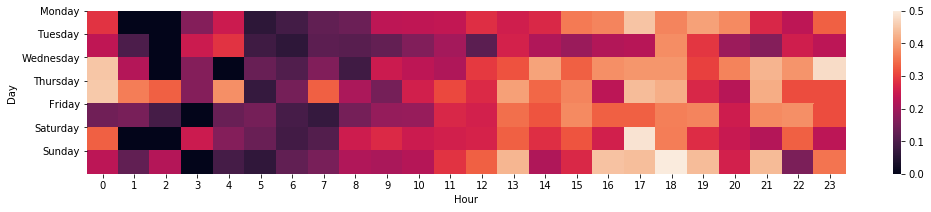

In [51]:
plt.figure(figsize=(17,3))
heat_weekdayhour = mta.pivot_table(index=mta.ScheduledArrivalTime.dt.day_name(), columns=mta.ScheduledArrivalTime.dt.hour, values="Late_Bus")
sns.heatmap(heat_weekdayhour,)
plt.xlabel('Hour')
plt.ylabel('Day')
plt.yticks(np.arange(7),weekday_order.values())
plt.show() 

The heatmap above shows the average late busses of the days of week by hour. There doesnt seem to be any significant difference between the hours that we normally associate with rush hour. it seems that there is just a steady increase of late busses from about 9:30 am up to midnight and then a lull between those times. 

# Late Busses and Time Delays by day of the Month

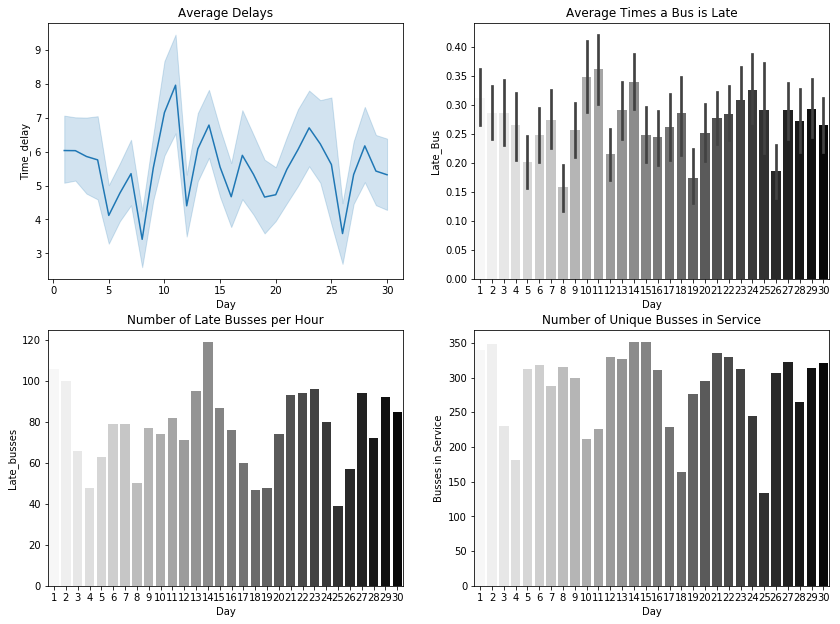

In [52]:
plt.figure(figsize=(14,16))
plt.subplot(321)
sns.lineplot(x= mta.ScheduledArrivalTime.dt.day , 
             y=mta.Time_delay, data=mta,)
plt.xlabel('Day')
plt.title('Average Delays')

plt.subplot(322)
sns.barplot(mta.ScheduledArrivalTime.dt.day,mta.Late_Bus,palette= "gist_gray_r")
plt.xlabel('Day')

plt.title('Average Times a Bus is Late')
 
plt.subplot(323)
sns.countplot(mta[mta.Late_Bus==1].ScheduledArrivalTime.dt.day , palette= "gist_gray_r")
plt.title('Number of Late Busses per Hour')
plt.xlabel('Day')

plt.ylabel('Late_busses')

plt.subplot(324)
#daydf = pd.DataFrame(mta.groupby('day').VehicleRef.unique())
#daydf = pd.DataFrame(daydf.VehicleRef.apply(lambda x : len(x)))
#daydf['day_of_month'] = daydf.index
#daydf.index = range(len(daydf))
#sns.barplot(daydf.day_of_month, daydf.VehicleRef,palette= "gist_gray_r")
sns.countplot(mta.ScheduledArrivalTime.dt.day, palette= "gist_gray_r")
plt.title('Number of Unique Busses in Service')
plt.xlabel('Day')
plt.ylabel('Busses in Service')

plt.show()

The days of the month seem to follow a weekly pattern. With the weekends having the least amount of late busses. The weekends also have fewer busses in service. The number of late busses doesn't seem to be affected by a larger number of busses in service.

In order to capture the cyclical nature of time sin/cos features of hour ,minute, and day of the week will be calculated so that the end of the cycle is show to be close to the beginning instead of far away.

In [53]:
# create sin cos features to capture cyclical nature
mta['sin_min'] = np.sin(mta['minute']*(2*np.pi/60))
mta['cos_min'] = np.cos(mta['minute']*(2*np.pi/60))
mta['sin_hour'] = np.sin(mta['hour']*(2.*np.pi/24))
mta['cos_hour'] = np.cos(mta['hour']*(2.*np.pi/24))
mta['sin_day_of_week'] = np.sin(mta['day_of_week']*(2.*np.pi/7))
mta['cos_day_of_week'] = np.cos(mta['day_of_week']*(2.*np.pi/7))

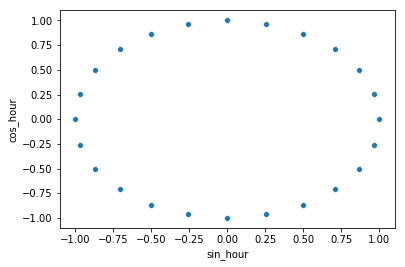

In [54]:
sns.scatterplot(mta.sin_hour,mta.cos_hour)

# Inbound and Outbound Late Busses and Delays

Let's see if there is any difference between the number of late busses of inbound vs outbound busses.

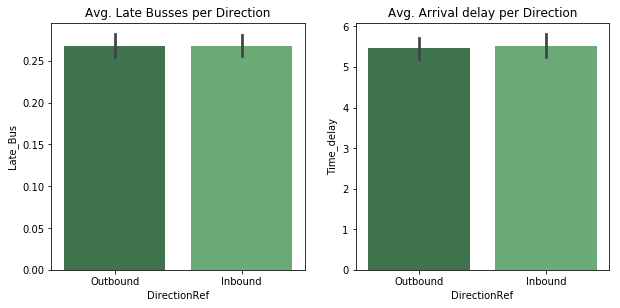

In [55]:
plt.figure(figsize=(10,10))
plt.subplot(221)
sns.barplot(y=mta.Late_Bus,x=mta.DirectionRef,palette="Greens_d",orient='vertical',) 
plt.title('Avg. Late Busses per Direction')
plt.xticks(range(0,2), ['Outbound','Inbound'])

plt.subplot(222)
sns.barplot(y=mta.Time_delay,x=mta.DirectionRef,palette="Greens_d",orient='vertical',) 
plt.title('Avg. Arrival delay per Direction')
plt.xticks(range(0,2), ['Outbound','Inbound'])
plt.show()

The average number of late busses is higher with the inbound busses as well as the average arrival delay.

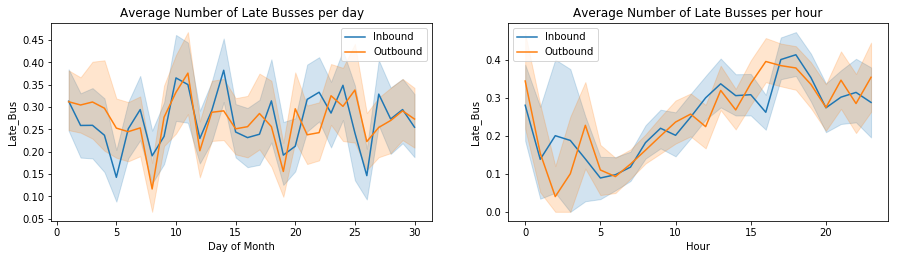

In [56]:
inbound_df = mta[mta.DirectionRef==1]
outbound_df = mta[mta.DirectionRef==0] 
plt.figure(figsize=(15,8))
plt.subplot(221)
sns.lineplot(inbound_df.ScheduledArrivalTime.dt.day.sort_values(), inbound_df.Late_Bus, label='Inbound') 
sns.lineplot(outbound_df.ScheduledArrivalTime.dt.day.sort_values(), outbound_df.Late_Bus, label='Outbound')
plt.title('Average Number of Late Busses per day')
plt.xticks=(np.arange(0,30,.5))
plt.xlabel('Day of Month')
plt.subplot(222)
sns.lineplot(inbound_df.ScheduledArrivalTime.dt.hour.sort_values(), inbound_df.Late_Bus, label='Inbound') 
sns.lineplot(outbound_df.ScheduledArrivalTime.dt.hour.sort_values(), outbound_df.Late_Bus, label='Outbound')
plt.title('Average Number of Late Busses per hour')
plt.xlabel('Hour')
plt.xticks=(np.arange(0,30,.5))
plt.show() 

The inbound and outbound busses show the same pattern over time. With respect hour there are more late inbound busses thoughout most of the day.

In [57]:
# Test of the mean distance between stops of late and on-time busses 
print(stats.ttest_ind(inbound_df.Late_Bus, outbound_df.Late_Bus),'\n')


Ttest_indResult(statistic=0.05609930687944847, pvalue=0.9552640011306389) 



## Distance from stop vs Late Busses 

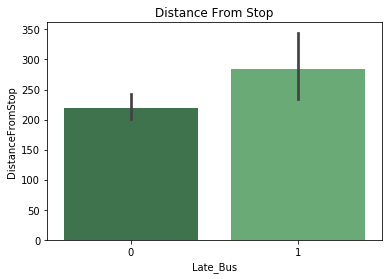

In [58]:
sns.barplot(x='Late_Bus',y='DistanceFromStop', data=mta, palette="Greens_d")
plt.title('Distance From Stop')
#plt.xticks(list(range(0,2)), ['On-Time','Late'])
plt.show()

In [59]:
print('Average distance from stop of on-time and late busses')
mta.groupby('Late_Bus').mean()[['DistanceFromStop']]

Average distance from stop of on-time and late busses


,DistanceFromStop
Late_Bus,
0,219.393033
1,283.685193


In [60]:
onTime_df = mta[mta.Late_Bus==1]
Late_df = mta[mta.Late_Bus==0] 
print('Ttest of average distance between stops of late and on-time Busses:')
print()
print(stats.ttest_ind(onTime_df.DistanceFromStop, Late_df.DistanceFromStop),'\n')

Ttest of average distance between stops of late and on-time Busses:

Ttest_indResult(statistic=2.7787024334065773, pvalue=0.0054695070396597305) 



The ttest shows a significant difference between the average distance from a stop and late busses.

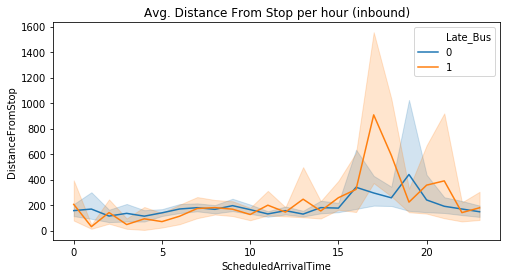

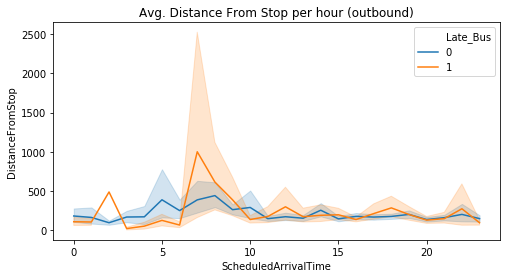

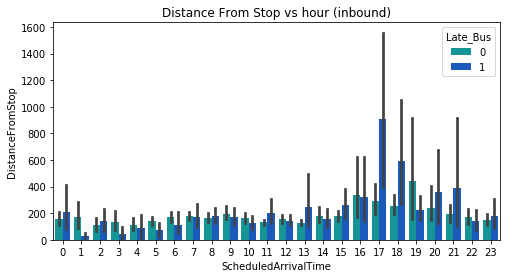

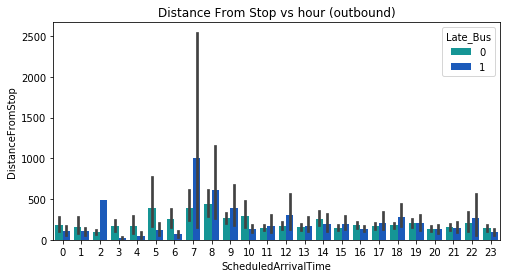

In [61]:
plt.figure(figsize=(8,4))
sns.lineplot(inbound_df.ScheduledArrivalTime.dt.hour.sort_values(), inbound_df.DistanceFromStop, hue=inbound_df.Late_Bus) 
plt.title('Avg. Distance From Stop per hour (inbound)')
plt.show()
plt.figure(figsize=(8,4))

sns.lineplot(outbound_df.ScheduledArrivalTime.dt.hour.sort_values(), outbound_df.DistanceFromStop, hue=outbound_df.Late_Bus)
plt.title('Avg. Distance From Stop per hour (outbound)')
#plt.xticks=(np.arange(0,30,.5))
plt.show() 
plt.figure(figsize=(8,4))
sns.barplot(inbound_df.ScheduledArrivalTime.dt.hour.sort_values(), inbound_df.DistanceFromStop,hue=inbound_df.Late_Bus,palette='winter_r')
plt.title('Distance From Stop vs hour (inbound)')
plt.show()
plt.figure(figsize=(8,4))
sns.barplot(outbound_df.ScheduledArrivalTime.dt.hour.sort_values(), outbound_df.DistanceFromStop,hue=outbound_df.Late_Bus,palette='winter_r')
plt.title('Distance From Stop vs hour (outbound)')
#sns.lineplot(mta.ScheduledArrivalTime.dt.hour.sort_values(), mta.DistanceFromStop, hue=mta.Late_Bus)

plt.show() 

There seems to be a pattern as the day goes on. The distacnce from stops increases for the inbound busses between 3pm and 9pm and for the outbound busses between 5am and 9am. The distance between stops for late busses is father than for the inbound busses than for the outbound. For the outbound busses it seems that distance between stops is greater for the on-time busses. This coincides with New Yorks rush hour. Since the busses are recorded approximately every ten minutes the busses are farther away from their stops for a longer amount of time because of traffic. This could possibly be why this pattern is showing. It doesn't explain the reason the distance between stops is greater for on time busses on the outbound side and the opposite for the inbound. This could be that there are more busses running at that time or that the busses are moving slower but the schedule accounts for those delays making the busses on time. 

I'm goding to create an indicator feature to mark this pattern.

In [62]:
# create rush our indicator feature
mta['rush_hour'] = np.where(np.logical_and(mta.hour>=5, mta.hour<=9) | np.logical_and(mta.hour>=15, mta.hour<=21),1,0)

## Which boroughs have the farthest distance from stop?


The route label prefixes signify the boroughs of New York that the operate in with the exception of routes that begin with "X". The "X" routes are express routes that a operate in all five boroghs and have large distances between stops. Here I will create a feature that groups the published line name(route) in to their areas of operation to condense dimentionality and for analysis.

In [63]:
# create new feature based on the route names and areas of operation based on prefix
def boroughs():
    mta['boroughs'] = '0'
    mta.loc[list(np.where((mta.PublishedLineName.str.contains('x')==False) & (mta.PublishedLineName.str.startswith('B')==True))[0]),'boroughs'] = 'Brooklyn'
    mta.loc[list(np.where(mta.PublishedLineName.str.startswith('Bx')==True)[0]),'boroughs'] = 'Bronx'
    mta.loc[list(np.where(mta.PublishedLineName.str.startswith('Q')==True)[0]),'boroughs'] = 'Queens'
    mta.loc[list(np.where(mta.PublishedLineName.str.startswith('S')==True)[0]),'boroughs'] = 'Staten Island'
    mta.loc[list(np.where(mta.PublishedLineName.str.startswith('M')==True)[0]),'boroughs'] = 'Manhattan'
    mta.loc[list(np.where(mta.PublishedLineName.str.startswith('X')==True)[0]),'boroughs'] = 'X'
    mta['boroughs'] = mta.boroughs.astype('category')
boroughs()


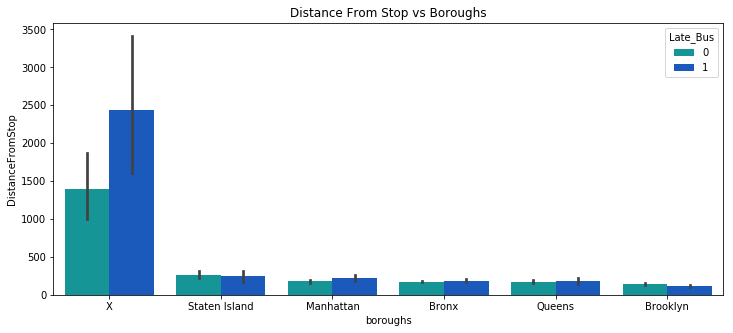

In [64]:
plt.figure(figsize=(12,5)) 
order = mta.groupby('boroughs').DistanceFromStop.mean().sort_values(ascending=False).index
sns.barplot(x='boroughs',y='DistanceFromStop' ,data=mta, hue=mta.Late_Bus,order=order,palette='winter_r')
plt.title('Distance From Stop vs Boroughs')
plt.show()

The "X" routes have the largest average distance from stops. It look like those routes are also resposible for the distance from stops for late busses being greater than the distance from stops for the on-time busses. Let's see what happens when we exclude the "X" routes.

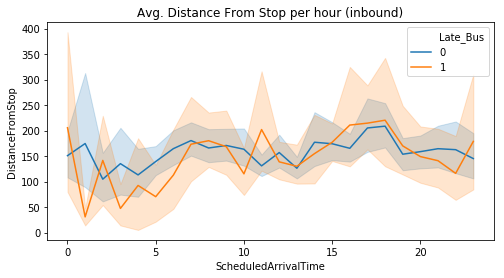

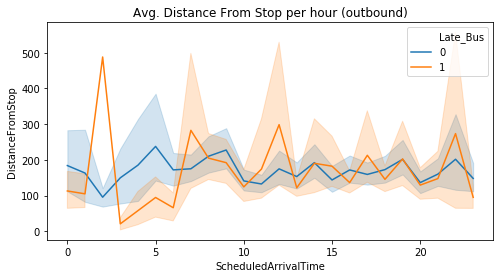

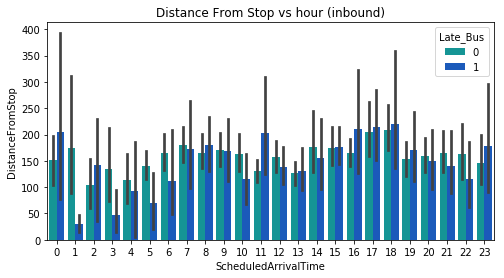

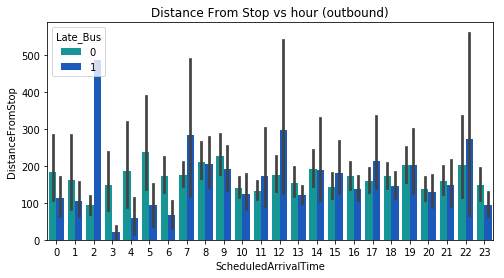

In [65]:
no_x_df = mta[mta.boroughs!='X']
inbound_df = no_x_df[no_x_df.DirectionRef==1]
outbound_df = no_x_df[no_x_df.DirectionRef==0] 

plt.figure(figsize=(8,4))
sns.lineplot(inbound_df.ScheduledArrivalTime.dt.hour.sort_values(), inbound_df.DistanceFromStop, hue=inbound_df.Late_Bus) 
plt.title('Avg. Distance From Stop per hour (inbound)')
plt.show()
plt.figure(figsize=(8,4))

sns.lineplot(outbound_df.ScheduledArrivalTime.dt.hour.sort_values(), outbound_df.DistanceFromStop, hue=outbound_df.Late_Bus)
plt.title('Avg. Distance From Stop per hour (outbound)')
#plt.xticks=(np.arange(0,30,.5))
plt.show() 
plt.figure(figsize=(8,4))
sns.barplot(inbound_df.ScheduledArrivalTime.dt.hour.sort_values(), inbound_df.DistanceFromStop,hue=inbound_df.Late_Bus,palette='winter_r')
plt.title('Distance From Stop vs hour (inbound)')
plt.show()
plt.figure(figsize=(8,4))
sns.barplot(outbound_df.ScheduledArrivalTime.dt.hour.sort_values(), outbound_df.DistanceFromStop,hue=outbound_df.Late_Bus,palette='winter_r')
plt.title('Distance From Stop vs hour (outbound)')
#sns.lineplot(mta.ScheduledArrivalTime.dt.hour.sort_values(), mta.DistanceFromStop, hue=mta.Late_Bus)

plt.show() 

Without the "X" routes the pattern pretty much disappears. This is something to be aware of when modeling because we don't want the algorithm to always focus in on the "X" routes.

In [66]:
#ttest between the means of the percentage of late busses of the days of the week
pvales = {}
for i in range(len(mta.boroughs.unique())):
        for j in range(i+1,6):
            print(mta.boroughs.unique()[i],' vs ',mta.boroughs.unique()[j]) 
            print(stats.ttest_ind(
                mta[mta.boroughs==mta.boroughs.unique()[i]]['Late_Bus'], 
                mta[mta.boroughs==mta.boroughs.unique()[j]]['Late_Bus']))
            pvales.update({(mta.boroughs.unique()[i],' vs ',mta.boroughs.unique()[j]):
                          stats.ttest_ind(
                          mta[mta.boroughs==mta.boroughs.unique()[i]]['Late_Bus'], 
                          mta[mta.boroughs==mta.boroughs.unique()[j]]['Late_Bus'])[1]})

Brooklyn  vs  Manhattan
Ttest_indResult(statistic=-1.6580233578308086, pvalue=0.0973847049365263)
Brooklyn  vs  Queens
Ttest_indResult(statistic=2.475619082508398, pvalue=0.013339247444802978)
Brooklyn  vs  X
Ttest_indResult(statistic=-1.2966384066158765, pvalue=0.19485423712160144)
Brooklyn  vs  Bronx
Ttest_indResult(statistic=1.7911050831096893, pvalue=0.07334481678822313)
Brooklyn  vs  Staten Island
Ttest_indResult(statistic=3.013303838724449, pvalue=0.002604514981919729)
Manhattan  vs  Queens
Ttest_indResult(statistic=3.7260477711325835, pvalue=0.0001977909541174714)
Manhattan  vs  X
Ttest_indResult(statistic=-0.3456027433270505, pvalue=0.7296765890562309)
Manhattan  vs  Bronx
Ttest_indResult(statistic=3.1318324235816157, pvalue=0.0017517541026995887)
Manhattan  vs  Staten Island
Ttest_indResult(statistic=3.8829155438516514, pvalue=0.00010623348505156677)
Queens  vs  X
Ttest_indResult(statistic=-2.6602478760815256, pvalue=0.007872363392352968)
Queens  vs  Bronx
Ttest_indResult(stat

In [67]:
# find all comparisons with pvalues > .05
non_significant = [i for i in pvales if pvales.get(i)>.05]
non_significant

[('Brooklyn', ' vs ', 'Manhattan'),
 ('Brooklyn', ' vs ', 'X'),
 ('Brooklyn', ' vs ', 'Bronx'),
 ('Manhattan', ' vs ', 'X'),
 ('Queens', ' vs ', 'Bronx'),
 ('Queens', ' vs ', 'Staten Island'),
 ('Bronx', ' vs ', 'Staten Island')]

## Compare boroughs to late busses

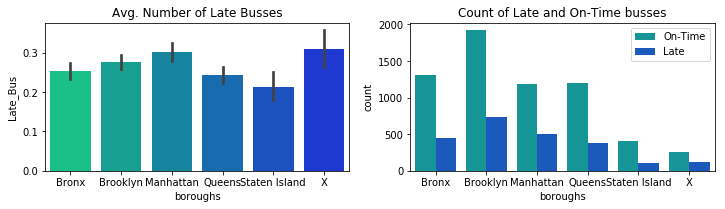

In [68]:
plt.figure(figsize=(12,6)) 
plt.subplot(221)
sns.barplot(x='boroughs',y='Late_Bus' ,data=mta,  palette='winter_r' )
plt.title('Avg. Number of Late Busses')

plt.subplot(222)
sns.countplot(x='boroughs',hue='Late_Bus' ,data=mta,  palette='winter_r' )
plt.legend(['On-Time','Late'])
plt.title('Count of Late and On-Time busses')
plt.show()

In [69]:
# chi-square test to test significance of group size
borough_count_table = pd.crosstab(mta.Late_Bus,mta.boroughs)
print('Chi-square Test Results significance of group size of boroughs')
print(stats.chisquare(borough_count_table, axis=None))


Chi-square Test Results significance of group size of boroughs
Power_divergenceResult(statistic=4938.341792782305, pvalue=0.0)


In [70]:
mta.groupby('boroughs').Late_Bus.agg(['mean','count'])

,mean,count
boroughs,,
Bronx,0.252991,1755
Brooklyn,0.277361,2668
Manhattan,0.300650,1693
Queens,0.242731,1582
Staten Island,0.213740,524
X,0.309783,368


Although the "X" routes are represented the least in the dataset they have the highest agverage of late busses. 

#  Geospacial features

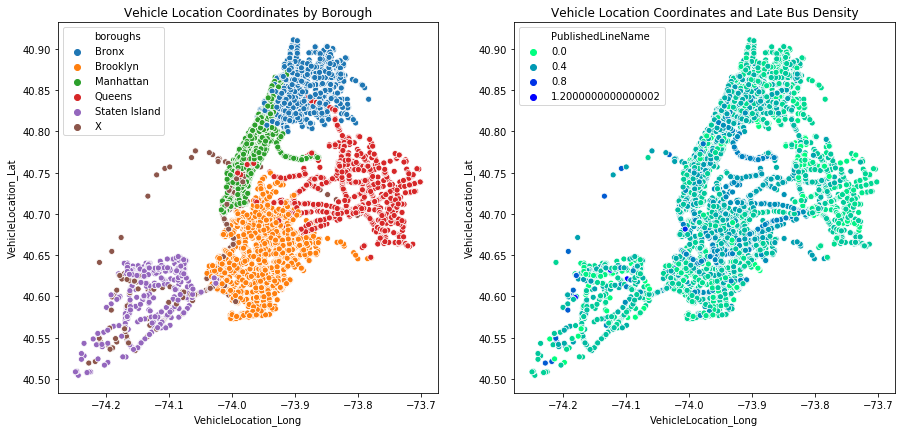

In [71]:
mean_late = mta.PublishedLineName.map(dict(mta.groupby('PublishedLineName').Late_Bus.mean().sort_values(ascending=False)))
plt.figure(figsize=(15,15))
 
plt.subplot(222)
sns.scatterplot(mta.VehicleLocation_Long,mta.VehicleLocation_Lat,hue=mean_late, palette='winter_r')
plt.title('Vehicle Location Coordinates and Late Bus Density')
 
plt.subplot(221)
sns.scatterplot(mta.VehicleLocation_Long,mta.VehicleLocation_Lat,hue=mta.boroughs)
plt.title('Vehicle Location Coordinates by Borough')
plt.show()

Above are scatterplots of the lattitudes and longitudes of the vehicle locations. You can see the shape of New York made from the lats and longs. There doesn't seem to be any points that fall far outside of the area that we are concerned with. The left plot shows the busses grouped by their respective areas of operation and the left highlights the areas where the average number of late busses is the greatest. This may indicate that vehicle location may be a good predictor of whether a bus is going to be late or not. Since there is no meaningful relationship between the raw lattitude and longitude I will create a couple of features to cut down on the dimentionality and well as creating something useful that a model such a Random Forest could use. 

In [72]:
# function to conver lat and long to zip code

def geo_to_zip(lat,long,zip_type):
    from uszipcode import SearchEngine
    from datetime import datetime
    startTime = datetime.now()
     
    search = SearchEngine(simple_zipcode=True)
    mta['col'] = mta[lat].astype(str)+' '+mta[long].astype(str)
    mta[zip_type] = mta['col'].apply(lambda x: search.by_coordinates(float(x.split()[0]),
                                    float(x.split()[1]), radius=10, returns=5)[0].values()[0])
   
    print(datetime.now() - startTime)
    print('done')
    mta.drop('col',1,inplace=True)
geo_to_zip('OriginLat', 'OriginLong','Orig_zip')
geo_to_zip('DestinationLat','DestinationLong','Dest_zip')
geo_to_zip('VehicleLocation_Lat','VehicleLocation_Long','VL_Zip')

0:01:12.941024
done
0:01:13.610705
done
0:01:13.562231
done


In [73]:

# fucntion to convert to compute distance between two points and create a columns of those distances
def distance_between_points(lat1,long1,lat2,long2,to_from):
    import mpu
    from datetime import datetime
    startTime = datetime.now()
    mta['point1'] =mta[lat1].astype(str)+" "+mta[long1].astype(str)
    mta['point2'] = mta[lat2].astype(str)+" "+mta[long2].astype(str)

    mta[to_from] = mta['point1']+" "+mta['point2']
    mta[to_from] = mta[to_from].apply(lambda x : mpu.haversine_distance((float(x.split()[0]), float(x.split()[1])),
                                                                              (float(x.split()[2]), float(x.split()[3]))))
    mta.drop('point1',1,inplace=True)
    mta.drop('point2',1,inplace=True)
    print(datetime.now() - startTime)
    print('done')
    return;


distance_between_points('VehicleLocation_Lat','VehicleLocation_Long','DestinationLat','DestinationLong','VL_to_Dest')
distance_between_points('VehicleLocation_Lat','VehicleLocation_Long','OriginLat', 'OriginLong','VL_to_Origin')
distance_between_points('DestinationLat','DestinationLong','OriginLat', 'OriginLong','Dest_to_Origin') 

0:00:00.077765
done
0:00:00.078789
done
0:00:00.081876
done


In [74]:
# winsorizing the distances to reduce outliers
mta["winVL_to_Dest"]  = winsorize(mta["VL_to_Dest"], (0, .1)) 
mta["winVL_to_Origin"] =winsor_distVL= winsorize(mta["VL_to_Origin"], (0, .1)) 
mta["winDest_to_Origin"] =winsor_distOD= winsorize(mta["Dest_to_Origin"], (0, .1))

In [75]:
#create geohash features from lat and long
import pygeohash as gh
mta['VL_geohash']=mta.apply(lambda x: gh.encode(x.VehicleLocation_Lat, x.VehicleLocation_Long, precision=5), axis=1).astype('category')
mta['O_geohash']=mta.apply(lambda x: gh.encode(x.OriginLat, x.OriginLong, precision=5), axis=1).astype('category')
mta['D_geohash']=mta.apply(lambda x: gh.encode(x.DestinationLat, x.DestinationLong, precision=5), axis=1).astype('category')

In [76]:
mta.head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation_Lat,VehicleLocation_Long,NextStopPointName,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime,Time_delay,Late_Bus,day,hour,minute,weekday,day_of_week,winsor_dist,increased_Late,time_of_day,is_midweek,sin_min,cos_min,sin_hour,cos_hour,sin_day_of_week,cos_day_of_week,rush_hour,boroughs,Orig_zip,Dest_zip,VL_Zip,VL_to_Dest,VL_to_Origin,Dest_to_Origin,winVL_to_Dest,winVL_to_Origin,winDest_to_Origin,VL_geohash,O_geohash,D_geohash
0,2017-06-01 00:13:38,0,B38,TILLARY ST/CADMAN PZ E,40.696106,-73.990364,RIDGEWOOD METRO AV,40.713341,-73.914688,NYCT_7228,40.687247,-73.976757,FULTON ST/LAFAYETTE AV,10.0,2017-06-01 00:13:57,2017-06-01 00:14:50,0.0,0,1,0,14,Thursday,3,10.0,0,night,1,9.945219e-01,0.104528,0.000000,1.000000,0.433884,-0.900969,0,Brooklyn,11201,11237,11217,5.983077,1.512116,6.660744,5.983077,1.512116,6.660744,dr5rk,dr5rs,dr5rw
1,2017-06-01 00:33:36,0,M2,4 AV/E 10 ST,40.731342,-73.990288,WASHINGTON HTS BWAY - 168 ST via MADISON,40.840580,-73.938431,NYCT_6420,40.801363,-73.953772,ADAM C POWELL BL/W 113 ST,19.0,2017-06-01 00:33:57,2017-06-01 00:30:41,3.0,0,1,0,30,Thursday,3,19.0,0,night,1,1.224647e-16,-1.000000,0.000000,1.000000,0.433884,-0.900969,0,Manhattan,10003,10032,10026,4.547792,8.371301,12.907516,4.547792,8.371301,12.907516,dr72j,dr5rs,dr72m
2,2017-06-01 00:43:30,0,Q30,ARCHER AV /SUTPHIN BL,40.700489,-73.807884,LITTLE NECK L NECK PKY,40.764297,-73.725914,NYCT_8089,40.718550,-73.791445,HOMELAWN ST/CHARLECOTE RIDGE,9.0,2017-06-01 00:43:41,2017-06-01 00:38:11,5.0,0,1,0,38,Thursday,3,9.0,0,night,1,-7.431448e-01,-0.669131,0.000000,1.000000,0.433884,-0.900969,0,Queens,11435,11005,11432,7.507057,2.439914,9.901728,7.507057,2.439914,9.901728,dr5x8,dr5x8,dr5xf
3,2017-06-01 01:03:25,0,M86-SBS,W 86 ST/BROADWAY,40.788357,-73.976791,Select Bus Service Yorkville East End AV,40.780247,-73.946808,NYCT_5835,40.776936,-73.949519,E 86 ST/1 AV,30.0,2017-06-01 01:03:49,2017-06-01 01:00:12,3.0,0,1,1,0,Thursday,3,30.0,0,night,1,0.000000e+00,1.000000,0.258819,0.965926,0.433884,-0.900969,0,Manhattan,10162,10028,10028,0.433190,2.623985,2.680625,0.433190,2.623985,2.680625,dr5rv,dr72h,dr5rv
4,2017-06-01 02:13:37,1,B15,JFK AIRPORT/TERMINAL 5 AirTrain STATION,40.647278,-73.779633,BED-STUY WOODHULL HOSP,40.699776,-73.941505,NYCT_6810,40.663602,-73.889098,NEW LOTS AV/WYONA ST,180.0,2017-06-01 02:14:09,2017-06-01 02:12:21,1.0,0,1,2,12,Thursday,3,180.0,0,night,1,9.510565e-01,0.309017,0.500000,0.866025,0.433884,-0.900969,0,Brooklyn,11422,11206,11207,5.975651,9.410855,14.847074,5.975651,9.410855,14.023785,dr5rq,dr5x1,dr5rt


In [77]:
ffff

NameError: name 'ffff' is not defined

In [94]:
mta.shape

(8590, 47)

# Preprcessing and Feature Selection

In [78]:

# import need libraries for models
from sklearn.naive_bayes import BernoulliNB 
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn import ensemble 
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

# fucntion to plot AUC/ROC curve and score
def AUC_ROC_plot(model,X_train,y_train,X_test,y_test,color): 
    model.fit(X_train , y_train)
    y_prob = cross_val_predict(model, X_test, y_test, method='predict_proba',cv=5)    
    auc = roc_auc_score(y_test,y_prob[:,1])
    print('AUC: %.3f' % auc)
    fpr, tpr,thresholds = roc_curve(y_test,y_prob[:,1])
    plt.plot(fpr,tpr,color)    
    plt.plot([0.0,1.0],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristics')
    plt.xlim([0.0,1.0])     
    plt.ylim([0.0,1.0])
    return;
 
# function to print metrics for comparison 
def Metrics(model, X_train , y_train, X_test, y_test,):
    model.fit(X_train , y_train)
    y_pred = model.predict(X_test) 
    y_prob = cross_val_predict(model, X_test, y_test, method='predict_proba',cv=5)    
    auc = roc_auc_score(y_test,y_prob[:,1])  
   
    print()
    print("Consfusion Matrix")
    print(pd.crosstab(y_test,y_pred))
    print()

    # Classification report
    print("Classification Report")
    from sklearn.metrics import classification_report   
    target_names = ['On-time','Late']
    print(classification_report(y_test,y_pred, target_names=target_names))    
    print("Train Score",model.score(X_train, y_train))
    print("Test Score",model.score(X_test, y_test))
    print("Recall Score",recall_score(y_test,y_pred))
    AUC_ROC_plot(model,X_train,y_train,X_test,y_test,'r')
    plt.show() 
    return;

# the next four fuctions convert features

# convert categorical to target mean in the training set
def cat_to_mean(X_train,X_test,cols=[]):
    X_trainC =  X_train.copy()
    X_testC =  X_test.copy()
    for col in X_trainC[cols]:
        Xmap = dict(X_train.groupby([col]).Late_Bus.mean())
        X_trainC[col] = X_trainC[col].map(Xmap)
        X_testC[col] =X_testC[col].map(Xmap)
        X_trainC.replace([np.inf, -np.inf], 0, inplace=True)
        X_testC.replace([np.inf, -np.inf], 0, inplace=True)
        X_trainC.fillna(0, inplace=True)
        X_testC.fillna(0, inplace=True)     

    return X_trainC, X_testC;

 

# convert categorical feature to the counts in the training set
def cat_to_count(X_train,X_test,cols=[]):
    X_trainC = X_train.copy()
    X_testC =  X_test.copy()
    for col in X_trainC[cols]:
        Xmap = dict(X_trainC[col].value_counts())
        X_trainC[col] = X_trainC[col].map(Xmap)
        X_testC[col] = X_testC[col].map(Xmap)
        X_trainC.replace([np.inf, -np.inf], 0, inplace=True)
        X_testC.replace([np.inf, -np.inf], 0, inplace=True)
        X_trainC.fillna(0, inplace=True)
        X_testC.fillna(0, inplace=True)
 
    return X_trainC, X_testC;

 

In [79]:
mta.columns

Index(['RecordedAtTime', 'DirectionRef', 'PublishedLineName', 'OriginName',
       'OriginLat', 'OriginLong', 'DestinationName', 'DestinationLat',
       'DestinationLong', 'VehicleRef', 'VehicleLocation_Lat',
       'VehicleLocation_Long', 'NextStopPointName', 'DistanceFromStop',
       'ExpectedArrivalTime', 'ScheduledArrivalTime', 'Time_delay', 'Late_Bus',
       'day', 'hour', 'minute', 'weekday', 'day_of_week', 'winsor_dist',
       'increased_Late', 'time_of_day', 'is_midweek', 'sin_min', 'cos_min',
       'sin_hour', 'cos_hour', 'sin_day_of_week', 'cos_day_of_week',
       'rush_hour', 'boroughs', 'Orig_zip', 'Dest_zip', 'VL_Zip', 'VL_to_Dest',
       'VL_to_Origin', 'Dest_to_Origin', 'winVL_to_Dest', 'winVL_to_Origin',
       'winDest_to_Origin', 'VL_geohash', 'O_geohash', 'D_geohash'],
      dtype='object')

In [80]:
mta.select_dtypes('category').describe()

,DirectionRef,PublishedLineName,OriginName,DestinationName,VehicleRef,NextStopPointName,weekday,time_of_day,boroughs,VL_geohash,O_geohash,D_geohash
count,8590,8590,8590,8590,8590,8590,8590,8590,8590,8590,8590,8590
unique,2,234,443,536,3574,4191,7,4,6,67,58,58
top,0,B6,E 126 ST/2 AV,WASHINGTON HTS GW BRIDGE,NYCT_4242,138 ST/37 AV,Thursday,morning,Brooklyn,dr5ru,dr72j,dr72m
freq,4331,165,134,108,10,20,1649,2849,2668,635,599,552


Since the geohashes and the zipcodes contain essentially the same information I am going to drop zipcodes because they have a higher cardinality. I will not be using vehicle reference either since the days and routes the unique busses run are not consistent. All of the other categroical features will be one-hot-encoded except for "NextStopPointName." It has over 5000 levels. I will encode it with the frequency that it occurs in the training set. This way we can still make use of it. 

Some of the other features will be dropped initally because eithere the are redundant or they were used to create the target variable. These features are: 'RecordedAtTime','DistanceFromStop','ExpectedArrivalTime', 'ScheduledArrivalTime', 'Time_delay', 'day', 'hour', 'minute',  'OriginLat', 'OriginLong','VehicleLocation_Lat','VehicleLocation_Long','Orig_zip', 'Dest_zip', 'VL_Zip''OriginName','DestinationName'.

There are some features that may be redundant but I'm not sure which will add more predictive power over the others so they will be left in and eliminated during feature selection.

In [81]:
mta.columns

Index(['RecordedAtTime', 'DirectionRef', 'PublishedLineName', 'OriginName',
       'OriginLat', 'OriginLong', 'DestinationName', 'DestinationLat',
       'DestinationLong', 'VehicleRef', 'VehicleLocation_Lat',
       'VehicleLocation_Long', 'NextStopPointName', 'DistanceFromStop',
       'ExpectedArrivalTime', 'ScheduledArrivalTime', 'Time_delay', 'Late_Bus',
       'day', 'hour', 'minute', 'weekday', 'day_of_week', 'winsor_dist',
       'increased_Late', 'time_of_day', 'is_midweek', 'sin_min', 'cos_min',
       'sin_hour', 'cos_hour', 'sin_day_of_week', 'cos_day_of_week',
       'rush_hour', 'boroughs', 'Orig_zip', 'Dest_zip', 'VL_Zip', 'VL_to_Dest',
       'VL_to_Origin', 'Dest_to_Origin', 'winVL_to_Dest', 'winVL_to_Origin',
       'winDest_to_Origin', 'VL_geohash', 'O_geohash', 'D_geohash'],
      dtype='object')

In [82]:
len(mta)

8590

In [83]:
modeling_df = mta[['DirectionRef','Late_Bus', 'PublishedLineName',
                   'weekday', 'day_of_week', 'winsor_dist', 'increased_Late',
                   'time_of_day', 'is_midweek', 'sin_hour', 'cos_hour', 'sin_day_of_week', 'cos_day_of_week',
                    'rush_hour',  'winVL_to_Dest', 'winVL_to_Origin','NextStopPointName',
                   'winDest_to_Origin','VL_geohash', 'O_geohash', 'D_geohash']]

dummies = ['time_of_day', 'VL_geohash', 'O_geohash', 'D_geohash','PublishedLineName',
         'weekday']

 
counts = ['NextStopPointName']
# one-hot-encoding using pandas get_dummies 
modeling_df = pd.concat([modeling_df.drop(dummies,1), pd.get_dummies(modeling_df[dummies],drop_first=True)], axis=1)
 
X  = modeling_df
Y = modeling_df.Late_Bus

# split the data 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=20)  

In [84]:
# count transformation 
X_train, X_test  = cat_to_count(X_train,X_test,counts)
X_train.sample(frac=.001)[:10]

,DirectionRef,Late_Bus,day_of_week,winsor_dist,increased_Late,is_midweek,sin_hour,cos_hour,sin_day_of_week,cos_day_of_week,rush_hour,winVL_to_Dest,winVL_to_Origin,NextStopPointName,winDest_to_Origin,time_of_day_evening,time_of_day_morning,time_of_day_night,VL_geohash_dr5nr,VL_geohash_dr5nw,VL_geohash_dr5nx,VL_geohash_dr5nz,VL_geohash_dr5pp,VL_geohash_dr5pr,VL_geohash_dr5q8,...,PublishedLineName_X21,PublishedLineName_X22,PublishedLineName_X22A,PublishedLineName_X27,PublishedLineName_X28,PublishedLineName_X3,PublishedLineName_X30,PublishedLineName_X31,PublishedLineName_X37,PublishedLineName_X38,PublishedLineName_X4,PublishedLineName_X42,PublishedLineName_X5,PublishedLineName_X63,PublishedLineName_X64,PublishedLineName_X68,PublishedLineName_X7,PublishedLineName_X8,PublishedLineName_X9,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
4156,0,0,3,388.0,1,0,0.866025,-5.000000e-01,0.433884,-0.900969,1,9.387542,7.557531,5,14.023785,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
8538,0,0,4,388.0,1,0,-1.000000,-1.836970e-16,-0.433884,-0.900969,1,8.672059,5.384461,2,14.023785,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3665,1,1,1,5.0,1,0,-1.000000,-1.836970e-16,0.781831,0.623490,1,6.471056,4.079746,1,10.540029,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2238,0,0,3,388.0,1,1,-0.965926,-2.588190e-01,0.433884,-0.900969,1,6.502621,5.971277,4,12.363562,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
505,0,0,4,80.0,1,1,-0.258819,-9.659258e-01,-0.433884,-0.900969,0,0.761166,2.880290,1,3.611871,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5822,0,0,2,152.0,1,0,0.500000,-8.660254e-01,0.974928,-0.222521,0,3.172276,9.277016,2,11.347358,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1003,0,1,6,73.0,1,1,-0.258819,-9.659258e-01,-0.781831,0.623490,0,0.747314,2.034735,5,2.680625,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


Next we'll take at a look at the correlations of the variables to the target. And start cutting down some of the dimentionality.

In [85]:
# find correlations to target
corr_matrix = X_train.corr().abs()
corr_to_target = corr_matrix['Late_Bus'].sort_values(ascending=False)

In [86]:
# top 30 features with the highest correlations to target
corr_to_target[:30]

Late_Bus                     1.000000
winVL_to_Origin              0.206697
sin_hour                     0.196452
winVL_to_Dest                0.147368
time_of_day_morning          0.144855
time_of_day_evening          0.133037
increased_Late               0.096567
NextStopPointName            0.079744
winDest_to_Origin            0.067926
PublishedLineName_B41        0.066868
weekday_Monday               0.063691
D_geohash_dr5rq              0.058920
PublishedLineName_B35        0.056338
day_of_week                  0.054777
VL_geohash_dr72j             0.051246
O_geohash_dr5rt              0.049386
PublishedLineName_M60-SBS    0.048836
PublishedLineName_Bx15       0.047512
O_geohash_dr5rs              0.045893
D_geohash_dr5r4              0.043920
PublishedLineName_B46-SBS    0.042412
PublishedLineName_M7         0.041703
VL_geohash_dr5xb             0.039565
O_geohash_dr5ry              0.039562
PublishedLineName_B82        0.038906
VL_geohash_dr5rx             0.038804
PublishedLin

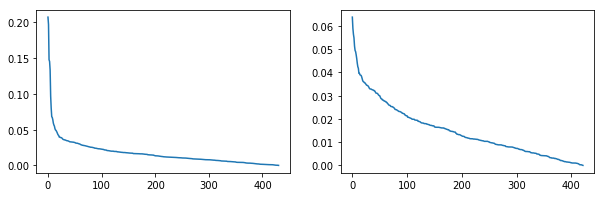

In [87]:
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(corr_to_target.values[1:])
plt.subplot(122)
plt.plot(corr_to_target.values[10:])
plt.show()

The correlation to target drops off pretty steep at around 25 features. But the first 10 features are numerical features and the rest are the dummies. On the left if we look at just the dummies variables then we can see that the elbow doesnt make a turn until between 150 and 200 features. This is were I will minimize the feature set to. 
Well start with order the features by their correlation to the target and the use sklearn's recursive feature selction tool.

In [88]:
#drop correlations that were nan and order feature columns from decending correlation scores
corr_to_target = dict(corr_to_target[:-1])  
X_train = X_train.loc[:,corr_to_target.keys()]
X_test = X_test.loc[:,corr_to_target.keys()]

In [89]:
# drop the target from independent features
X_train.drop('Late_Bus',1,inplace=True)
X_test.drop('Late_Bus',1,inplace=True)

In [90]:
# recusive feature selection using logistic regression 
lr = LogisticRegression(max_iter=300, solver= 'liblinear', warm_start= True)

from sklearn.feature_selection import RFE
# feature extraction
rfe = RFE(lr, n_features_to_select=150)
# fit on train set
fit = rfe.fit(X_train, y_train)
# transform train set
recursive_features = fit.transform(X_train)
 

In [91]:
X_train = X_train.iloc[:,pd.DataFrame(recursive_features).columns] 
X_test = X_test.iloc[:,pd.DataFrame(recursive_features).columns] 

In [92]:
X_train.shape

(6872, 150)

Next I'll take a look at the heatmap of the correlation matrix to see if any features are highly correlated. If so Well drop one of the correlated features and keep the one that is most highly correlated with the target.

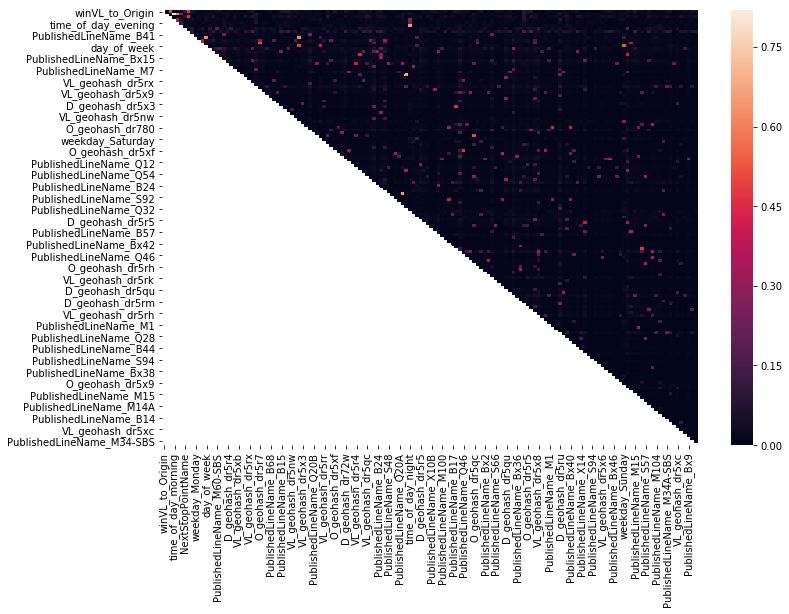

In [95]:
corr_matrix = X_train.corr().abs().where(np.triu(np.ones(X_train.corr().abs().shape), k=1).astype(np.bool))
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix,annot=False)
plt.show()

In [96]:
to_drop = [column for column in corr_matrix.columns if any(corr_matrix[column] > 0.50)]
print('Columns to drop: ' , (len(to_drop)))
to_drop

Columns to drop:  9


['time_of_day_morning',
 'time_of_day_evening',
 'day_of_week',
 'O_geohash_dr5r7',
 'cos_day_of_week',
 'O_geohash_dr5r0',
 'PublishedLineName_Q32',
 'time_of_day_night',
 'weekday_Sunday']

In [97]:
# Drop one of each pair of correlated features
X_train.drop(to_drop,1,inplace=True)
X_test.drop(to_drop,1,inplace=True)


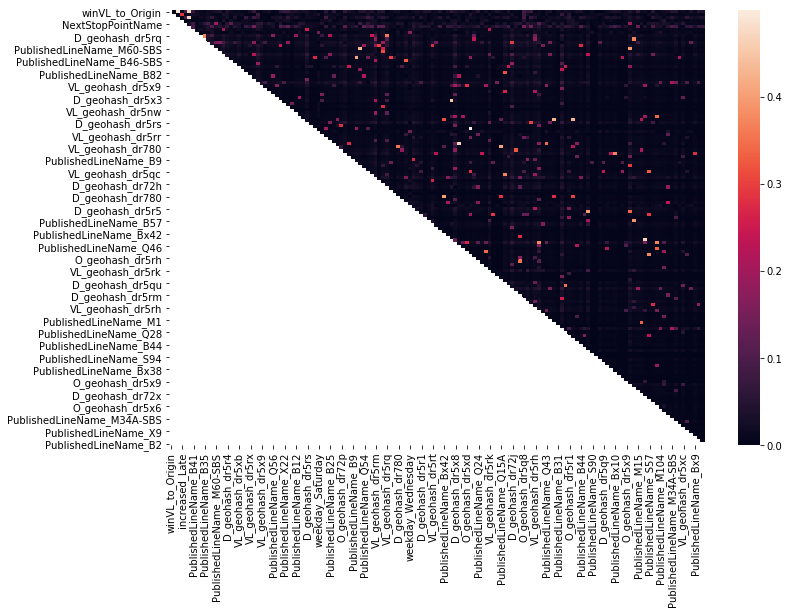

In [98]:
corr_matrix = X_train.corr().abs().where(np.triu(np.ones(X_train.corr().abs().shape), k=1).astype(np.bool))
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix,annot=False)
plt.show()

In [99]:
print(X_train.shape) 
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(6872, 141)
(6872,)
(1718, 141)
(1718,)


Since the we are dealing with and imbalanced dataset I'll use a random oversampler function to create more random instances of the minority class to balance the training set only.

In [100]:
import imblearn
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=20)
X_trainB, y_trainB = ros.fit_sample(X_train, y_train)

C:\Users\keith\AppData\Roaming\Python\Python37\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


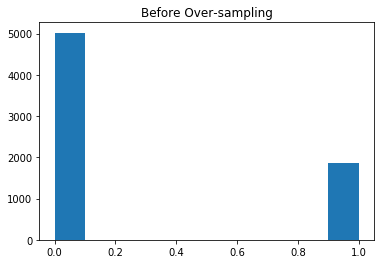

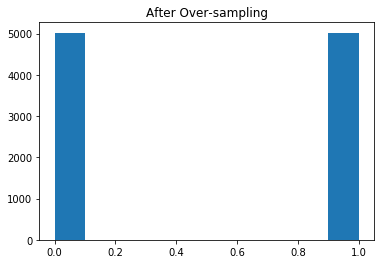

In [101]:
plt.hist(y_train)
plt.title('Before Over-sampling')
plt.show()
plt.hist(y_trainB)
plt.title('After Over-sampling')
plt.show()

In [102]:
# scale the data
from sklearn.preprocessing import StandardScaler
sclr = StandardScaler()
sclr.fit(X_trainB)
X_trainS = sclr.transform(X_trainB)
X_testS = sclr.transform(X_test)


# Modeling

### Random Forest  

Random Forest

Consfusion Matrix
col_0        0    1
Late_Bus           
0         1083  184
1          296  155

Classification Report
              precision    recall  f1-score   support

     On-time       0.79      0.85      0.82      1267
        Late       0.46      0.34      0.39       451

    accuracy                           0.72      1718
   macro avg       0.62      0.60      0.61      1718
weighted avg       0.70      0.72      0.71      1718

Train Score 0.9959163346613545
Test Score 0.7206053550640279
Recall Score 0.3436807095343681
AUC: 0.649


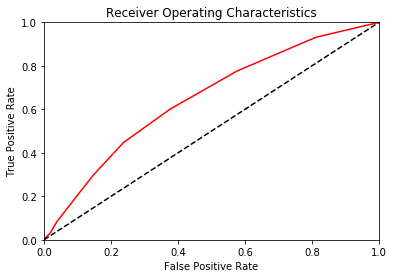

In [109]:
rfc = ensemble.RandomForestClassifier(n_estimators=10,class_weight='balanced',random_state=20)
print(str('Random Forest'))
Metrics(rfc, X_trainS , y_trainB, X_testS, y_test)  

In [ ]:
# define a function to extract best params from GridsearchCV
from sklearn.model_selection import GridSearchCV
def gridsearch(model, X_trainS , y_trainB, param_grid):    
    grid = GridSearchCV(model, param_grid, cv=3, scoring='roc_auc', return_train_score=True,verbose=1,n_jobs=-1)
    grid.fit(X_trainS , y_trainB)
    print(grid.best_params_)
    print(grid.best_score_)

## Perceptron

Iteration 1, loss = 0.65055607
Iteration 2, loss = 0.58477039
Iteration 3, loss = 0.56007535
Iteration 4, loss = 0.54500079
Iteration 5, loss = 0.53288651
Iteration 6, loss = 0.52234672
Iteration 7, loss = 0.51239655
Iteration 8, loss = 0.50104308
Iteration 9, loss = 0.49396833
Iteration 10, loss = 0.48413477
Iteration 11, loss = 0.47810496
Iteration 12, loss = 0.46754494
Iteration 13, loss = 0.46001750
Iteration 14, loss = 0.44819673
Iteration 15, loss = 0.44020069
Iteration 16, loss = 0.43328258
Iteration 17, loss = 0.43113030
Iteration 18, loss = 0.41680001
Iteration 19, loss = 0.41006736
Iteration 20, loss = 0.40124461
Iteration 21, loss = 0.39357982
Iteration 22, loss = 0.38603038
Iteration 23, loss = 0.37986921
Iteration 24, loss = 0.37374705
Iteration 25, loss = 0.36531520
Iteration 26, loss = 0.36031899
Iteration 27, loss = 0.35121675
Iteration 28, loss = 0.34317271
Iteration 29, loss = 0.33830158
Iteration 30, loss = 0.33185342
Iteration 31, loss = 0.32431813
Iteration 32, los

Iteration 88, loss = 0.06928573
Iteration 89, loss = 0.06604408
Iteration 90, loss = 0.06482956
Iteration 91, loss = 0.06507084
Iteration 92, loss = 0.06306803
Iteration 93, loss = 0.06112100
Iteration 94, loss = 0.06074113
Iteration 95, loss = 0.05862638
Iteration 96, loss = 0.05949053
Iteration 97, loss = 0.06062308
Iteration 98, loss = 0.05870682
Iteration 99, loss = 0.06049614
Iteration 100, loss = 0.05264823
Iteration 101, loss = 0.05331471
Iteration 102, loss = 0.05200239
Iteration 103, loss = 0.05178499
Iteration 104, loss = 0.04858180
Iteration 105, loss = 0.05009932
Iteration 106, loss = 0.04784800
Iteration 107, loss = 0.04908564
Iteration 108, loss = 0.05314813
Iteration 109, loss = 0.05397618
Iteration 110, loss = 0.05114448
Iteration 111, loss = 0.05342078
Iteration 112, loss = 0.05834633
Iteration 113, loss = 0.04896535
Iteration 114, loss = 0.04776897
Iteration 115, loss = 0.04495659
Iteration 116, loss = 0.04443128
Iteration 117, loss = 0.04410896
Iteration 118, loss = 

Iteration 144, loss = 0.03611798
Iteration 145, loss = 0.03865876
Iteration 146, loss = 0.03353477
Iteration 147, loss = 0.03403709
Iteration 148, loss = 0.03681542
Iteration 149, loss = 0.03301993
Iteration 150, loss = 0.03447506
Iteration 151, loss = 0.03480267
Iteration 152, loss = 0.03356491
Iteration 153, loss = 0.03555562
Iteration 154, loss = 0.03880923
Iteration 155, loss = 0.03363218
Iteration 156, loss = 0.03801540
Iteration 157, loss = 0.03460054
Iteration 158, loss = 0.03723363
Iteration 159, loss = 0.04198905
Iteration 160, loss = 0.04225771
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.61104907
Iteration 2, loss = 0.56949182
Iteration 3, loss = 0.55416013
Iteration 4, loss = 0.53838284
Iteration 5, loss = 0.52056310
Iteration 6, loss = 0.50431110
Iteration 7, loss = 0.48756086
Iteration 8, loss = 0.47049684
Iteration 9, loss = 0.45560063
Iteration 10, loss = 0.44328800
Iteration 11, loss = 0.42795285
Iterat

Iteration 78, loss = 0.07250773
Iteration 79, loss = 0.07054008
Iteration 80, loss = 0.06926601
Iteration 81, loss = 0.06827022
Iteration 82, loss = 0.07219381
Iteration 83, loss = 0.07184460
Iteration 84, loss = 0.06862114
Iteration 85, loss = 0.06492505
Iteration 86, loss = 0.06584544
Iteration 87, loss = 0.06746874
Iteration 88, loss = 0.06058061
Iteration 89, loss = 0.06131590
Iteration 90, loss = 0.05934090
Iteration 91, loss = 0.05893677
Iteration 92, loss = 0.05970768
Iteration 93, loss = 0.05612503
Iteration 94, loss = 0.05644167
Iteration 95, loss = 0.05382104
Iteration 96, loss = 0.05260237
Iteration 97, loss = 0.05233427
Iteration 98, loss = 0.05211141
Iteration 99, loss = 0.05284991
Iteration 100, loss = 0.05127084
Iteration 101, loss = 0.05000402
Iteration 102, loss = 0.05399310
Iteration 103, loss = 0.05142798
Iteration 104, loss = 0.05759432
Iteration 105, loss = 0.05157734
Iteration 106, loss = 0.05031223
Iteration 107, loss = 0.05056791
Iteration 108, loss = 0.04764878

C:\Users\keith\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 7, loss = 0.48714895
Iteration 8, loss = 0.47200820
Iteration 9, loss = 0.45777468
Iteration 10, loss = 0.44411562
Iteration 11, loss = 0.43147595
Iteration 12, loss = 0.42020316
Iteration 13, loss = 0.40962859
Iteration 14, loss = 0.40067021
Iteration 15, loss = 0.39057563
Iteration 16, loss = 0.38284362
Iteration 17, loss = 0.37385700
Iteration 18, loss = 0.36741040
Iteration 19, loss = 0.35962657
Iteration 20, loss = 0.35258288
Iteration 21, loss = 0.34432688
Iteration 22, loss = 0.33848314
Iteration 23, loss = 0.33199188
Iteration 24, loss = 0.32577998
Iteration 25, loss = 0.31889672
Iteration 26, loss = 0.31213088
Iteration 27, loss = 0.30668109
Iteration 28, loss = 0.29995298
Iteration 29, loss = 0.29567689
Iteration 30, loss = 0.28773154
Iteration 31, loss = 0.28348901
Iteration 32, loss = 0.27603639
Iteration 33, loss = 0.26969019
Iteration 34, loss = 0.26340457
Iteration 35, loss = 0.25814627
Iteration 36, loss = 0.25241128
Iteration 37, loss = 0.24649398
Iteration 3

Iteration 99, loss = 0.06049614
Iteration 100, loss = 0.05264823
Iteration 101, loss = 0.05331471
Iteration 102, loss = 0.05200239
Iteration 103, loss = 0.05178499
Iteration 104, loss = 0.04858180
Iteration 105, loss = 0.05009932
Iteration 106, loss = 0.04784800
Iteration 107, loss = 0.04908564
Iteration 108, loss = 0.05314813
Iteration 109, loss = 0.05397618
Iteration 110, loss = 0.05114448
Iteration 111, loss = 0.05342078
Iteration 112, loss = 0.05834633
Iteration 113, loss = 0.04896535
Iteration 114, loss = 0.04776897
Iteration 115, loss = 0.04495659
Iteration 116, loss = 0.04443128
Iteration 117, loss = 0.04410896
Iteration 118, loss = 0.04209583
Iteration 119, loss = 0.04166889
Iteration 120, loss = 0.04169673
Iteration 121, loss = 0.04078904
Iteration 122, loss = 0.04274276
Iteration 123, loss = 0.03840669
Iteration 124, loss = 0.04272935
Iteration 125, loss = 0.03895367
Iteration 126, loss = 0.04025777
Iteration 127, loss = 0.04098507
Iteration 128, loss = 0.04290826
Iteration 1

Iteration 159, loss = 0.04198905
Iteration 160, loss = 0.04225771
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.61104907
Iteration 2, loss = 0.56949182
Iteration 3, loss = 0.55416013
Iteration 4, loss = 0.53838284
Iteration 5, loss = 0.52056310
Iteration 6, loss = 0.50431110
Iteration 7, loss = 0.48756086
Iteration 8, loss = 0.47049684
Iteration 9, loss = 0.45560063
Iteration 10, loss = 0.44328800
Iteration 11, loss = 0.42795285
Iteration 12, loss = 0.41901544
Iteration 13, loss = 0.40820244
Iteration 14, loss = 0.39741160
Iteration 15, loss = 0.38816057
Iteration 16, loss = 0.38096213
Iteration 17, loss = 0.37212882
Iteration 18, loss = 0.36669588
Iteration 19, loss = 0.35823784
Iteration 20, loss = 0.34978766
Iteration 21, loss = 0.34163762
Iteration 22, loss = 0.33536541
Iteration 23, loss = 0.32742165
Iteration 24, loss = 0.32111094
Iteration 25, loss = 0.31487425
Iteration 26, loss = 0.30846250
Iteration 27, loss = 

Iteration 96, loss = 0.05260237
Iteration 97, loss = 0.05233427
Iteration 98, loss = 0.05211141
Iteration 99, loss = 0.05284991
Iteration 100, loss = 0.05127084
Iteration 101, loss = 0.05000402
Iteration 102, loss = 0.05399310
Iteration 103, loss = 0.05142798
Iteration 104, loss = 0.05759432
Iteration 105, loss = 0.05157734
Iteration 106, loss = 0.05031223
Iteration 107, loss = 0.05056791
Iteration 108, loss = 0.04764878
Iteration 109, loss = 0.04980487
Iteration 110, loss = 0.04676518
Iteration 111, loss = 0.04496264
Iteration 112, loss = 0.04223422
Iteration 113, loss = 0.04344462
Iteration 114, loss = 0.04048042
Iteration 115, loss = 0.04650296
Iteration 116, loss = 0.04550006
Iteration 117, loss = 0.04195488
Iteration 118, loss = 0.04303250
Iteration 119, loss = 0.04001855
Iteration 120, loss = 0.04165620
Iteration 121, loss = 0.04201269
Iteration 122, loss = 0.04168788
Iteration 123, loss = 0.03954798
Iteration 124, loss = 0.03649705
Iteration 125, loss = 0.03914866
Iteration 126,

C:\Users\keith\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.61334055
Iteration 2, loss = 0.57243488
Iteration 3, loss = 0.55680137
Iteration 4, loss = 0.54106566
Iteration 5, loss = 0.52260009
Iteration 6, loss = 0.50450555
Iteration 7, loss = 0.48714895
Iteration 8, loss = 0.47200820
Iteration 9, loss = 0.45777468
Iteration 10, loss = 0.44411562
Iteration 11, loss = 0.43147595
Iteration 12, loss = 0.42020316
Iteration 13, loss = 0.40962859
Iteration 14, loss = 0.40067021
Iteration 15, loss = 0.39057563
Iteration 16, loss = 0.38284362
Iteration 17, loss = 0.37385700
Iteration 18, loss = 0.36741040
Iteration 19, loss = 0.35962657
Iteration 20, loss = 0.35258288
Iteration 21, loss = 0.34432688
Iteration 22, loss = 0.33848314
Iteration 23, loss = 0.33199188
Iteration 24, loss = 0.32577998
Iteration 25, loss = 0.31889672
Iteration 26, loss = 0.31213088
Iteration 27, loss = 0.30668109
Iteration 28, loss = 0.29995298
Iteration 29, loss = 0.29567689
Iteration 30, loss = 0.28773154
Iteration 31, loss = 0.28348901
Iteration 32, los

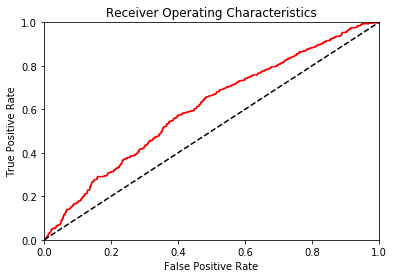

In [124]:
from sklearn.neural_network import MLPClassifier

# Establish and fit the model, with a single, 1000 perceptron layer.
mlp = MLPClassifier(hidden_layer_sizes=(100,50,10),random_state=20, verbose=True,max_iter=200,warm_start=True)
Metrics(mlp, X_trainS , y_trainB, X_testS, y_test)

Initally there is overfitting on both models. The AUC scores aren't terrible but the Random Forest is not picking up very many late busses. Possibly tuning the hyperparameter can fix some of these issues.

### Tuning hyperparameters using GridsearchCV

In [ ]:
# initiate GridsearchCV for best parameters
from sklearn.model_selection import GridSearchCV
def gridsearch(model, X_trainS , y_trainB, param_grid):    
    grid = GridSearchCV(model, param_grid, cv=3, scoring='roc_auc', return_train_score=True,verbose=1)
    grid.fit(X_trainS , y_trainB)
    print(grid.best_params_)
    print(grid.best_score_)

# random forest classifier
rfc =  ensemble.RandomForestClassifier(n_estimators=10,random_state=20,warm_start=True)   

# parameters to search
param_grid = { 'n_estimators': range(2,30),'max_depth' : range(1,10),'max_leaf_nodes':range(2,10,1)}
# gridsearch
gridsearch(rfc, X_train , y_train, param_grid)

In [ ]:
# run classifer with new params
print('Random Forest')
rfc = ensemble.RandomForestClassifier(max_features='auto',max_depth=8, max_leaf_nodes=9,n_estimators=10,class_weight='balanced',random_state=20)
Metrics(rfc, X_trainS , y_trainB, X_testS, y_test)
print('Cross validataion scores:',cross_val_score(lr, X_train, y_train, cv=10))

In [ ]:
 
# Establish and fit the model, with a single, 1000 perceptron layer.
mlp = MLPClassifier(hidden_layer_sizes=(100,2,2,1),activation='identity')
#mlp.fit(X, Y)

In [ ]:
Metrics(mlp, X_trainS , y_trainB, X_testS, y_test)

In [ ]:
print('Cross validataion scores:',cross_val_score(mlp, X_train, y_train, cv=10))

In [93]:
# define a function to extract best params from GridsearchCV
from sklearn.model_selection import GridSearchCV
def gridsearch(model, X_trainS , y_trainB, param_grid):    
    grid = GridSearchCV(model, param_grid, cv=3, scoring='roc_auc', return_train_score=True,verbose=1,n_jobs=-1)
    grid.fit(X_trainS , y_trainB)
    print(grid.best_params_)
    print(grid.best_score_)